# Modeling Census Tract Data

* Census data is provided in [census_income_learn.csv](0_raw/census_income_learn.csv)
* Raw metadata is provided in [census_income_metadata.txt](0_raw/census_income_metadata.txt)
* Census data does not contain column labels
* Manually extracted and cleaned column names from raw metadata file above to create new file containing column names for the census dataset: [census_col_labels.csv](0_raw/census_col_labels.csv)

In [1]:
# set flags
FULL_VERBOSE = True
MAKE_PLOTS = True
SAVE_PLOTS = False

In [2]:
# setup
inputdata = '0_raw/census_income_learn.csv'
metadata = '0_raw/census_col_labels.csv'
out_dir = '1_results'

In [3]:
# import libraries
import pandas as pd
import numpy as np
import re
import os
from pycaret.classification import *

if MAKE_PLOTS:
    import matplotlib.pyplot as plt
    import seaborn as sns

if SAVE_PLOTS:
    from matplotlib.backends.backend_pdf import PdfPages

In [4]:
# define a custom print function
def custom_print(text):
    print("#" * 80)
    print(text)
    print("#" * 80)
    print("\n")

In [5]:
# read in the data
census_df = pd.read_csv(inputdata, header=None)
col_labels = pd.read_csv(metadata)

In [6]:
# create output directory if it doesn't exist
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [7]:
# print number of rows and columns in the census dataset
custom_print(f"Number of rows (raw): {census_df.shape[0]}")
custom_print(f"Number of columns (raw): {census_df.shape[1]}")

# show what the data looks like
custom_print(f"Raw data:\n{census_df.head()}")

################################################################################
Number of rows (raw): 199523
################################################################################


################################################################################
Number of columns (raw): 42
################################################################################


################################################################################
Raw data:
   0                                1   2   3                            4   \
0  73                  Not in universe   0   0         High school graduate   
1  58   Self-employed-not incorporated   4  34   Some college but no degree   
2  18                  Not in universe   0   0                   10th grade   
3   9                  Not in universe   0   0                     Children   
4  10                  Not in universe   0   0                     Children   

   5                 6               7           

In [8]:
# add col labels to census df
census_df.columns = col_labels.iloc[:,1].tolist()

## Exploratory Data Analysis I

In [9]:
# show what the data looks like
custom_print(f"Raw data with col labels:\n{census_df.head()}")

################################################################################
Raw data with col labels:
   age                  class_of_worker  detailed_industry_recode  \
0   73                  Not in universe                         0   
1   58   Self-employed-not incorporated                         4   
2   18                  Not in universe                         0   
3    9                  Not in universe                         0   
4   10                  Not in universe                         0   

   detailed_occupation_recode                    education  wage_per_hour  \
0                           0         High school graduate              0   
1                          34   Some college but no degree              0   
2                           0                   10th grade              0   
3                           0                     Children              0   
4                           0                     Children              0   

  enroll_in_edu

In [10]:
if FULL_VERBOSE:
    # info about all variables
    print(census_df.info())
    
    # summary of numerical columns
    census_df.select_dtypes(include=['number']).describe()
    
    # summary of categorical columns
    categorical_columns = census_df.select_dtypes(include=['object','category']).columns
    for col in categorical_columns:
        custom_print(f"Summary of {col}:\n{census_df[col].value_counts(dropna=False)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class_of_worker                             199523 non-null  object 
 2   detailed_industry_recode                    199523 non-null  int64  
 3   detailed_occupation_recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage_per_hour                               199523 non-null  int64  
 6   enroll_in_edu_inst_last_wk                  199523 non-null  object 
 7   marital_stat                                199523 non-null  object 
 8   major_industry_code                         199523 non-null  object 
 9   major_occupation_code                       199523 non-null  object 
 

## Preprocessing

In [11]:
# following terms are used to describe NAs in the dataset
na_list = ['Not in universe', 'Not in universe or children', 'Do not know', '?', 'Not identifiable', 'Not in universe under 1 year old']

# replace these terms with NA by rereading in the census data
census_df_clean = pd.read_csv('0_raw/census_income_learn.csv', header=None, names=col_labels.iloc[:,1].tolist(), na_values=na_list, keep_default_na=True, skipinitialspace=True)

In [12]:
# for several vars, 0 represents a missing value, hence replace 0 with NA in those vars
cols_to_convert = ['wage_per_hour','capital_gains','capital_losses','dividends_from_stocks','num_persons_worked_for_employer','own_business_or_self_employed','weeks_worked_in_year']
census_df_clean[cols_to_convert] = census_df_clean[cols_to_convert].replace(0, np.nan)

# for "own_business_or_self_employed", replace 1 with "Yes" and 2 with "No"
census_df_clean['own_business_or_self_employed'] = census_df_clean['own_business_or_self_employed'].replace({1: 'Yes', 2: 'No'})

# column "year" only has 2 values: 94 and 95. Convert this to a categorical var
census_df_clean['year'] = census_df_clean['year'].astype('category')

In [13]:
custom_print(f"Shape before dropping rows with 70% or more NAs: {census_df_clean.shape}")

# drop rows with 70% or more NAs
census_df_clean = census_df_clean.dropna(thresh=int(0.3 * census_df_clean.shape[1]))

custom_print(f"Shape after dropping rows with 70% or more NAs: {census_df_clean.shape}")

################################################################################
Shape before dropping rows with 70% or more NAs: (199523, 42)
################################################################################


################################################################################
Shape after dropping rows with 70% or more NAs: (199523, 42)
################################################################################




In [14]:
# create new var from education by combining levels to create new classes "NoDegree", "Associates", "Bachelors", "Masters", "Doctorate", "ProfSchool"
census_df_clean['new_education'] = census_df_clean['education']
my_flag = census_df_clean['new_education'].str.contains('no degree|grade|children|High school', case=False, na=False)
census_df_clean.loc[my_flag,'new_education'] = 'NoDegree'
census_df_clean['new_education'] = census_df_clean['new_education'].replace({
    'Associates degree-occup /vocational': 'Associates', 
    'Associates degree-academic program': 'Associates', 
    'Bachelors degree(BA AB BS)': 'Bachelors', 
    'Masters degree(MA MS MEng MEd MSW MBA)': 'Masters', 
    'Doctorate degree(PhD EdD)': 'Doctorate', 
    'Prof school degree (MD DDS DVM LLB JD)': 'ProfSchool'
})

# create new var from class of worker by combining private + self-employed and combining federal + local + state government
census_df_clean['new_class_of_worker'] = census_df_clean['class_of_worker'].replace({
    'Private': 'Private', 
    'Self-employed-not incorporated': 'Private', 
    'Self-employed-incorporated': 'Private', 
    'Federal government': 'Government', 
    'Local government': 'Government', 
    'State government': 'Government', 
    'Never worked': pd.NA, 
    'Without pay': pd.NA
})

# create new var called "moved" from "migration_code-move_within_reg" by converting "Nonmover" to "No" and all other values to "Yes"
census_df_clean['moved'] = census_df_clean['migration_code-move_within_reg'].apply(lambda x: 'No' if x == 'Nonmover' else ('Yes' if pd.notna(x) else pd.NA))

# create new var from family_members_under_18 called "both_parents_present" by converting "Both parents present" to "Yes" and all other values to "No"
census_df_clean['both_parents_present'] = census_df_clean['family_members_under_18'].replace({
    'Both parents present': 'Yes',
    'Mother only present': 'No',
    'Father only present': 'No',
    'Neither parent present': 'No'
})

# create new var called "american_father" from "country_of_birth_father" by converting "United-States" to "Yes" and all other values to "No"
census_df_clean['american_father'] = census_df_clean['country_of_birth_father'].apply(lambda x: 'Yes' if x == 'United-States' else ('No' if pd.notna(x) else pd.NA))

# create new var called "american_mother" from "country_of_birth_mother" by converting "United-States" to "Yes" and all other values to "No"
census_df_clean['american_mother'] = census_df_clean['country_of_birth_mother'].apply(lambda x: 'Yes' if x == 'United-States' else ('No' if pd.notna(x) else pd.NA))

# for the target variable, replace "- 50000." with "lessthan50k" and "50000+." with "morethan50k"
census_df_clean['target'] = census_df_clean['target'].replace({'- 50000.': 'lessthan50k', '50000+.': 'morethan50k'})


In [15]:
# apply one hot encoding with preserved NAs to all discrete variables
discrete_vars = ['new_education','race','hispanic_origin','region_of_previous_residence']
temp_df = pd.DataFrame(index=census_df_clean.index)

for col in discrete_vars:
    # create flag for NA values
    nan_flag = census_df_clean[col].isna()
    
    # create dummies for this column
    dummies = pd.get_dummies(census_df_clean[col], drop_first=True, dtype=float, prefix=col)
    
    # use NA flag to add NAs to all dummy columns
    for dummy_col in dummies.columns:
        dummies.loc[nan_flag, dummy_col] = np.nan
    
    # append to temp_df
    temp_df = pd.concat([temp_df, dummies], axis=1)

# combine original columns with one hot encoded columns
census_df_clean = pd.concat([census_df_clean.drop(discrete_vars, axis=1), temp_df], axis=1)

In [16]:
# drop column "instance_weight" since the metadata file mentions that this variable is not to be used for modeling
census_df_clean = census_df_clean.drop(columns=['instance_weight'])

In [17]:
if FULL_VERBOSE:
    # info about all variables
    print(census_df_clean.info())
    
    # updated summary of numerical columns
    census_df_clean.select_dtypes(include=['number']).describe()
    
    # updated summary of categorical columns
    categorical_columns = census_df_clean.select_dtypes(include=['object','category']).columns
    for col in categorical_columns:
        custom_print(f"Summary of {col}:\n{census_df_clean[col].value_counts(dropna=False)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 63 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   age                                         199523 non-null  int64   
 1   class_of_worker                             99278 non-null   object  
 2   detailed_industry_recode                    199523 non-null  int64   
 3   detailed_occupation_recode                  199523 non-null  int64   
 4   education                                   199523 non-null  object  
 5   wage_per_hour                               11304 non-null   float64 
 6   enroll_in_edu_inst_last_wk                  12580 non-null   object  
 7   marital_stat                                199523 non-null  object  
 8   major_industry_code                         98839 non-null   object  
 9   major_occupation_code                       98839 non-null 

## Exploratory Data Analysis II

In [18]:
# variables to keep
## get column names of new one hot encoded variables
tempnames = []
for string in discrete_vars:
    discrete_cols = [col for col in census_df_clean.columns if string in col]
    tempnames.extend(discrete_cols)
tempnames = list(set(tempnames))
## list of categorical variable names
vars_keep_categorical = ['new_education','race','hispanic_origin','sex','member_of_a_labor_union','region_of_previous_residence','live_in_this_house_1_year_ago','migration_prev_res_in_sunbelt','year','new_class_of_worker','moved','both_parents_present','american_father','american_mother']
## drop original discrete variable column names since they have been replaced by one hot encoded variables
vars_keep_categorical = [x for x in vars_keep_categorical if x not in discrete_vars]
## add column names of new one hot encoded variables to list of categorical variable names
vars_keep_categorical.extend(tempnames)
vars_keep_categorical = list(set(vars_keep_categorical))
## list of numerical variable names
vars_keep_numerical = ['age','wage_per_hour','capital_gains','capital_losses','dividends_from_stocks','weeks_worked_in_year']

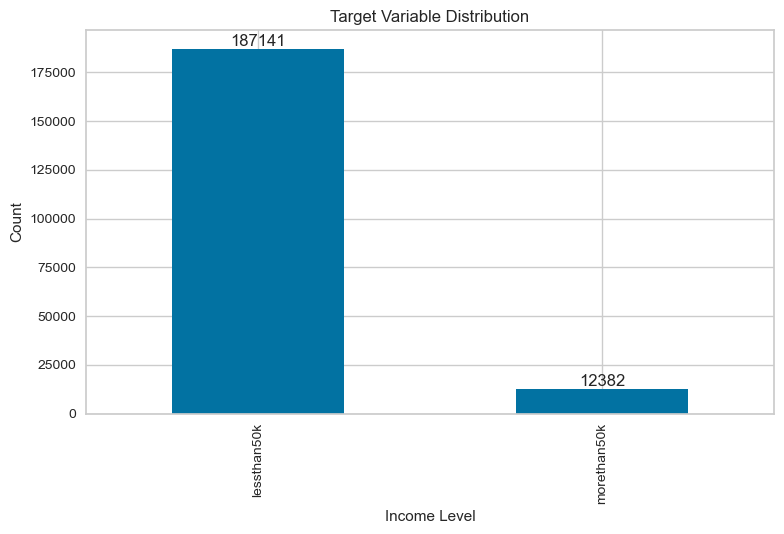

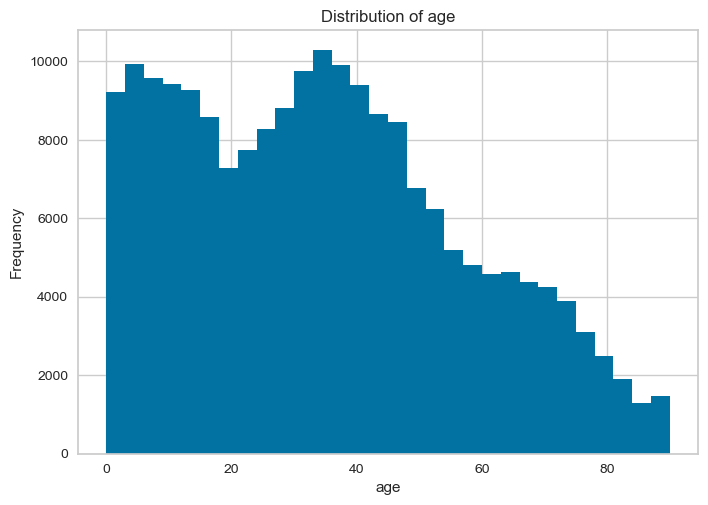

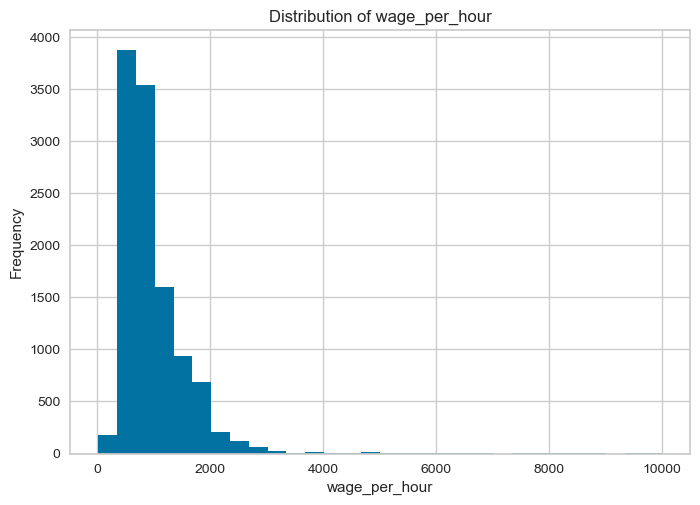

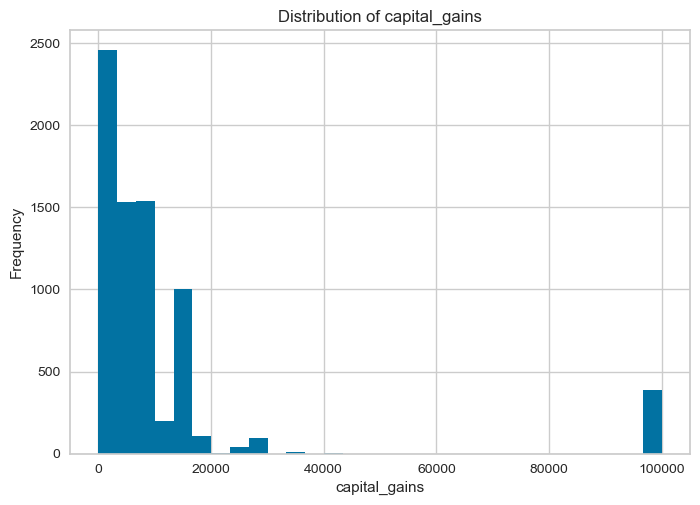

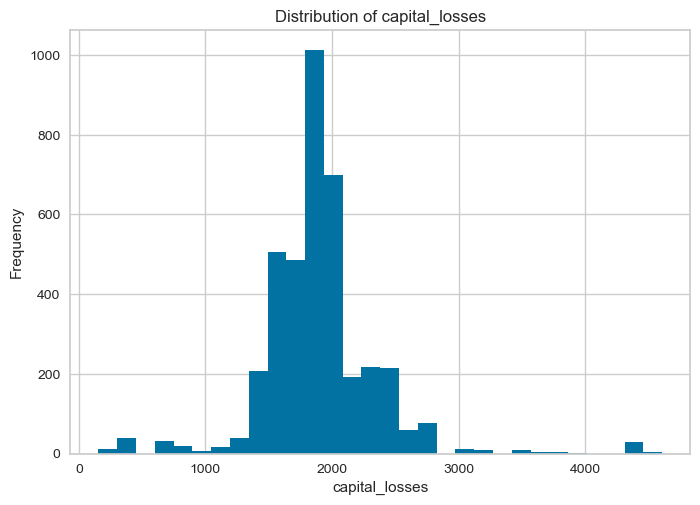

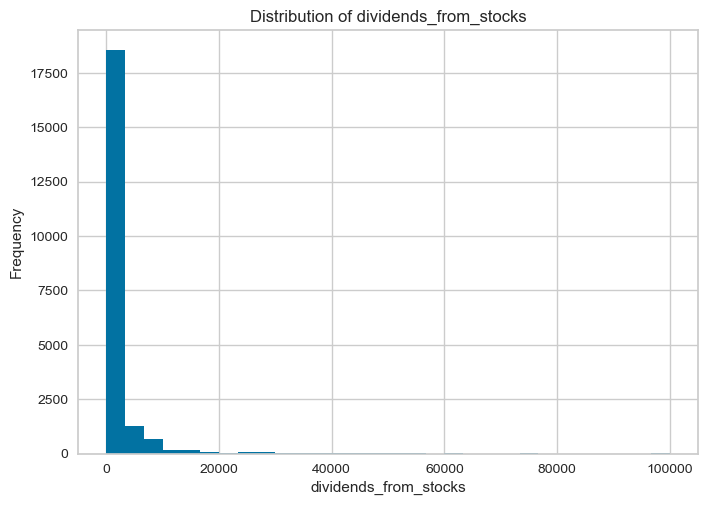

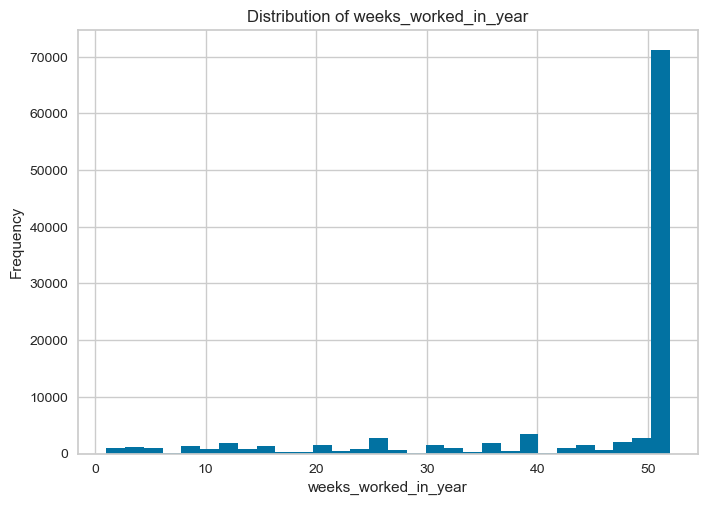

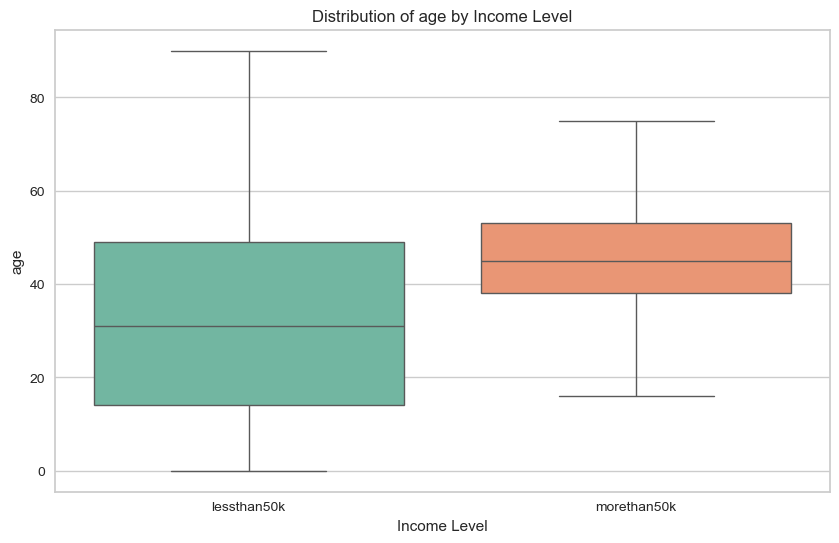

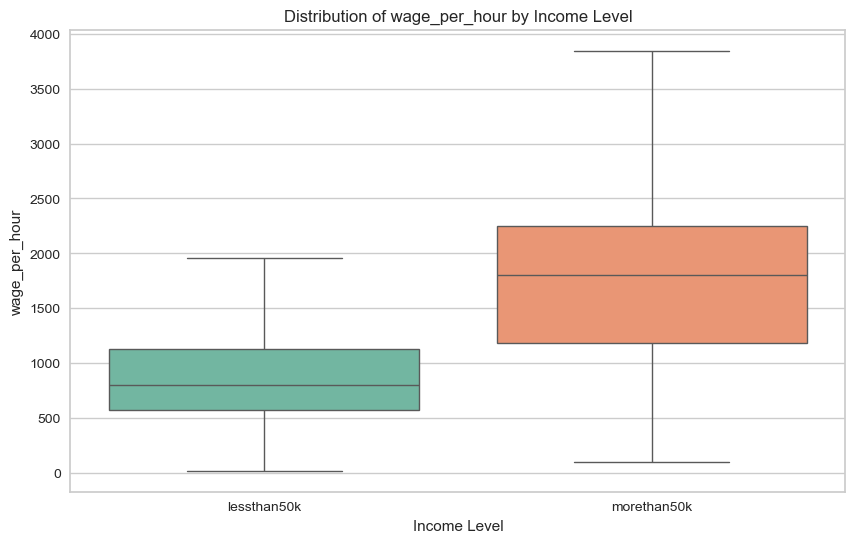

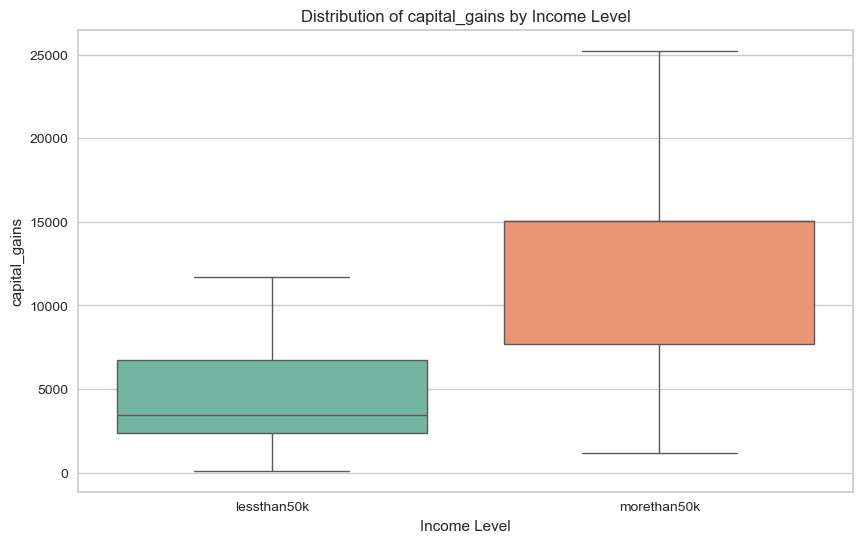

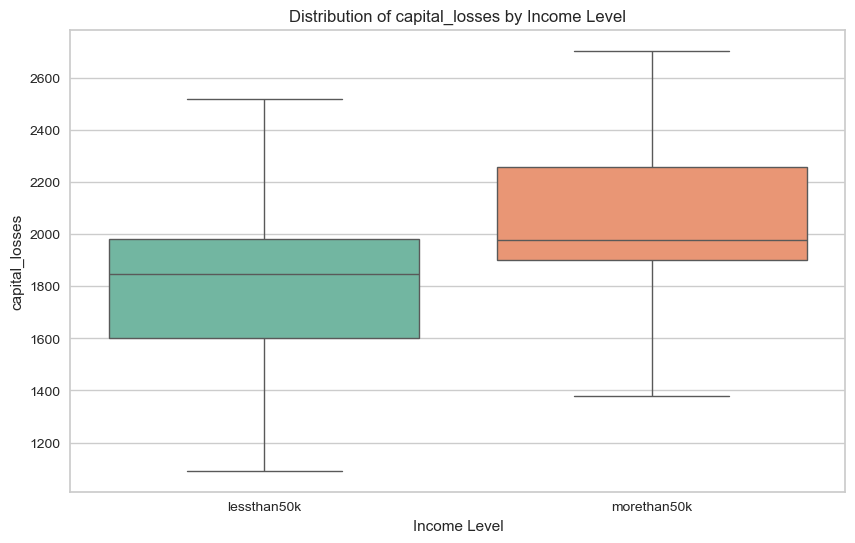

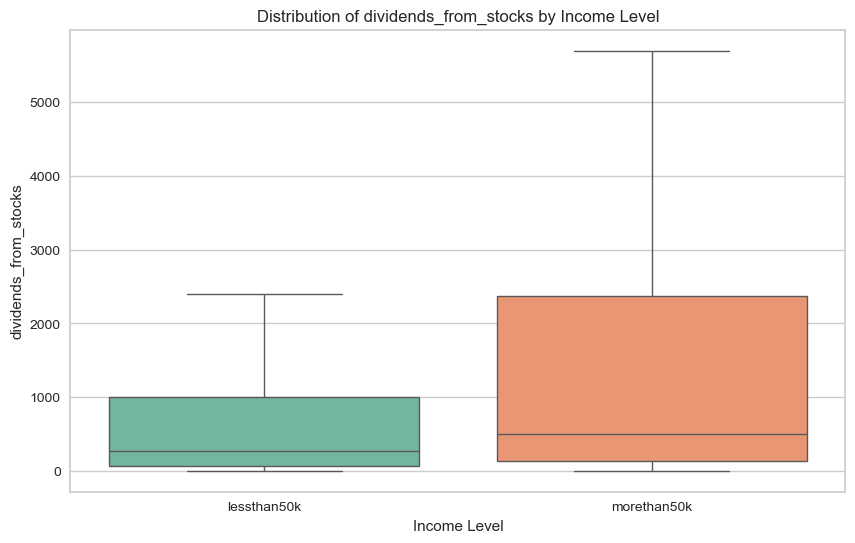

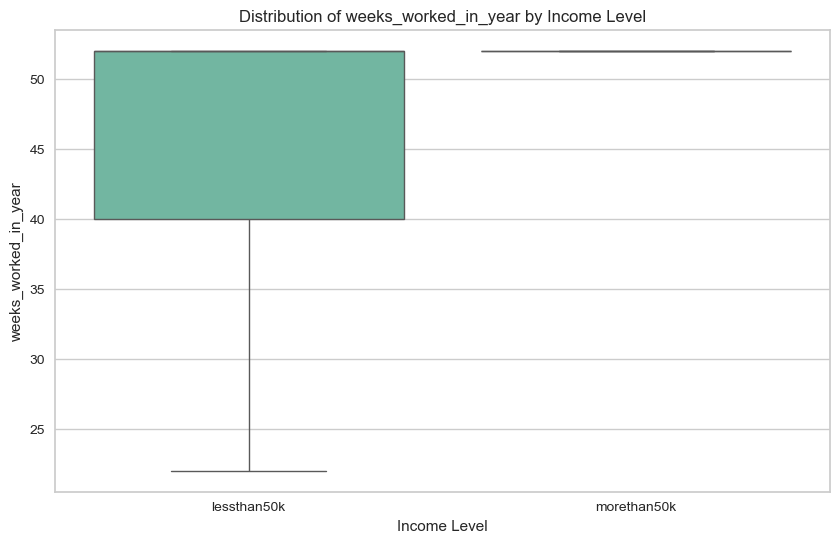

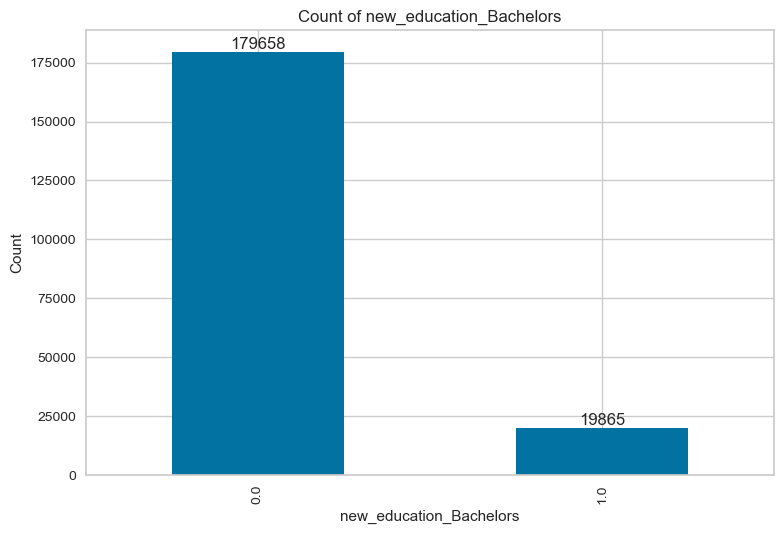

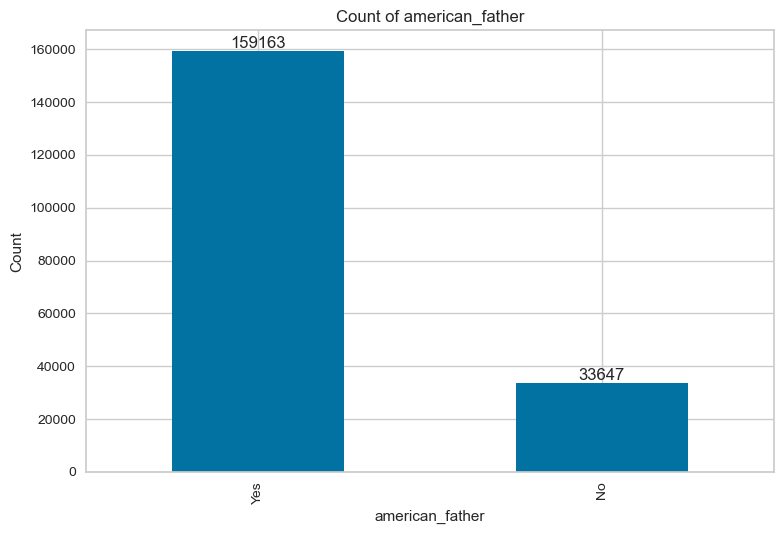

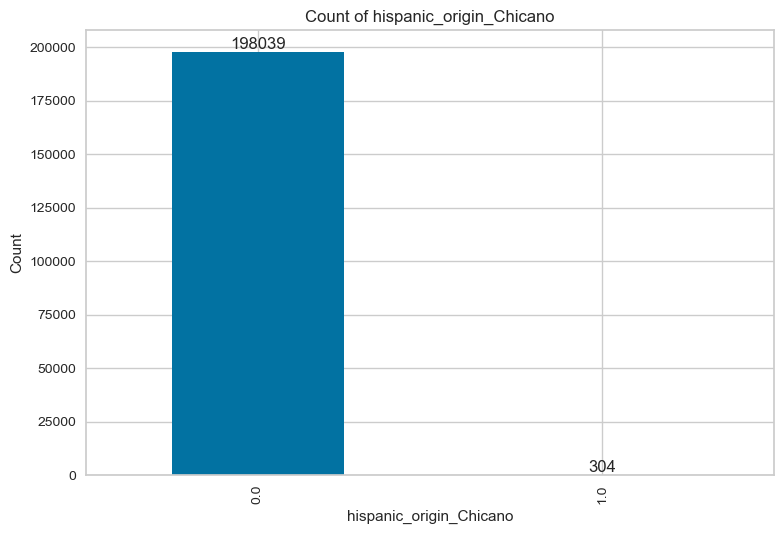

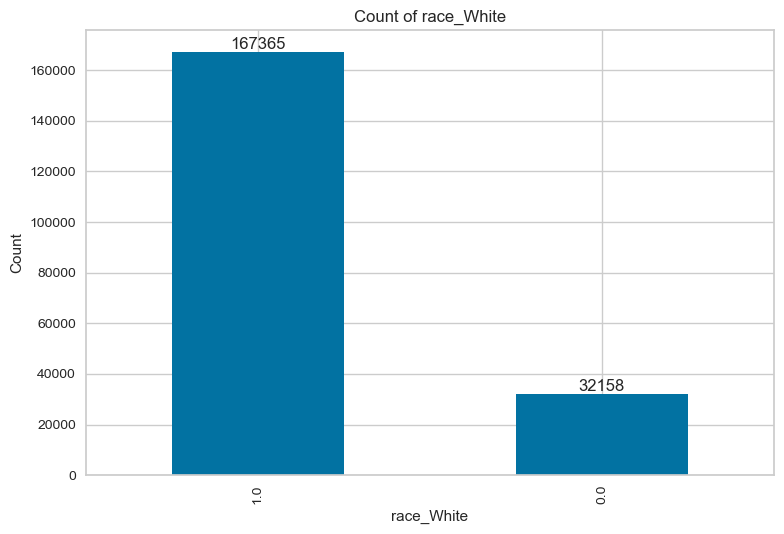

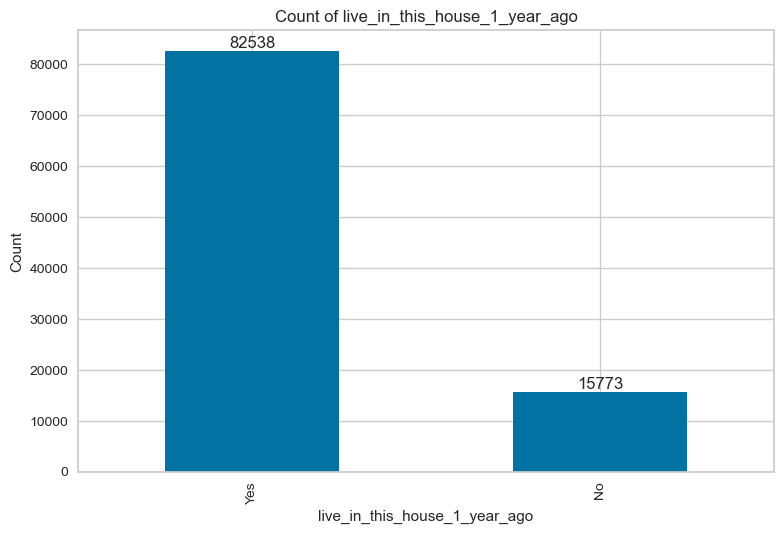

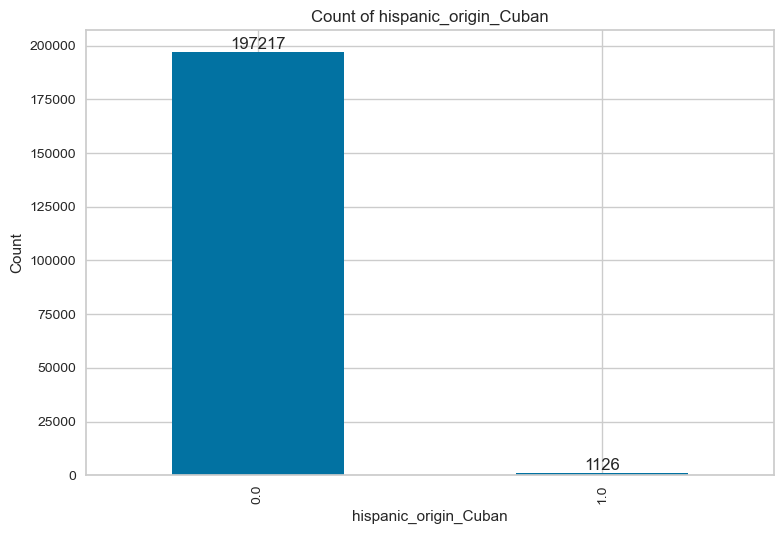

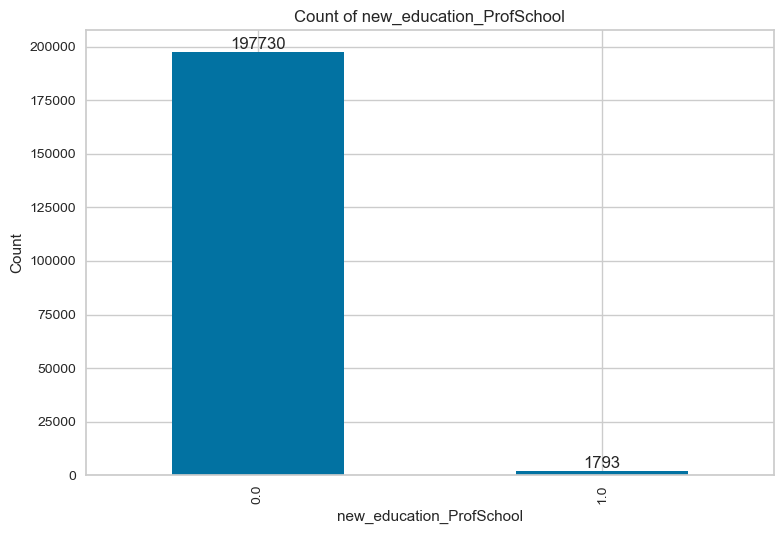

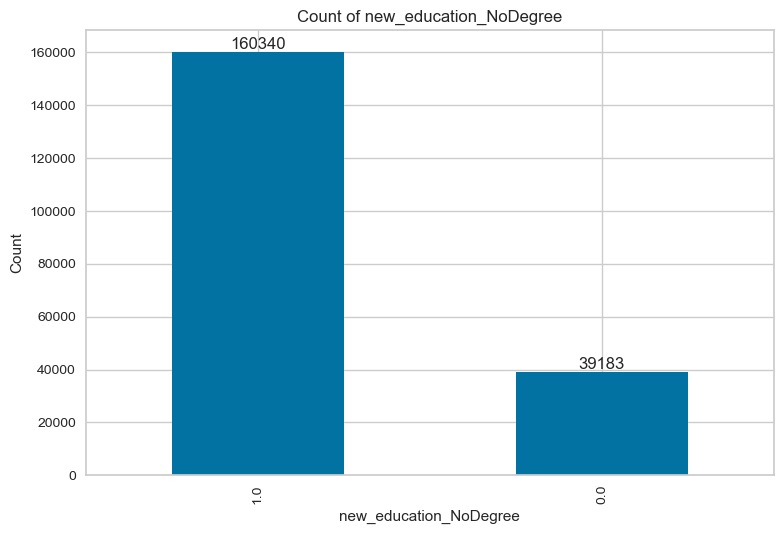

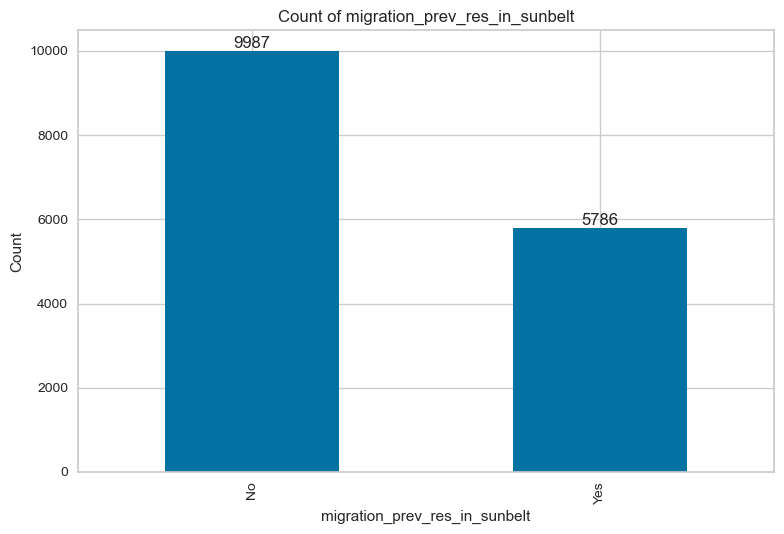

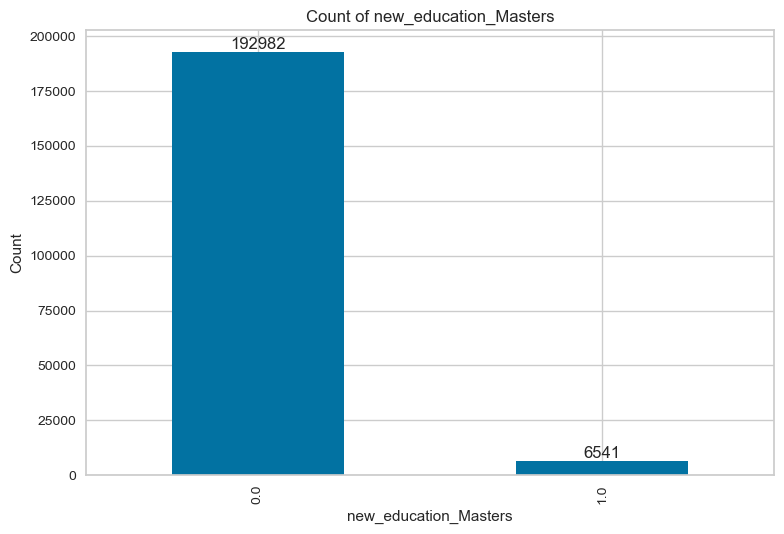

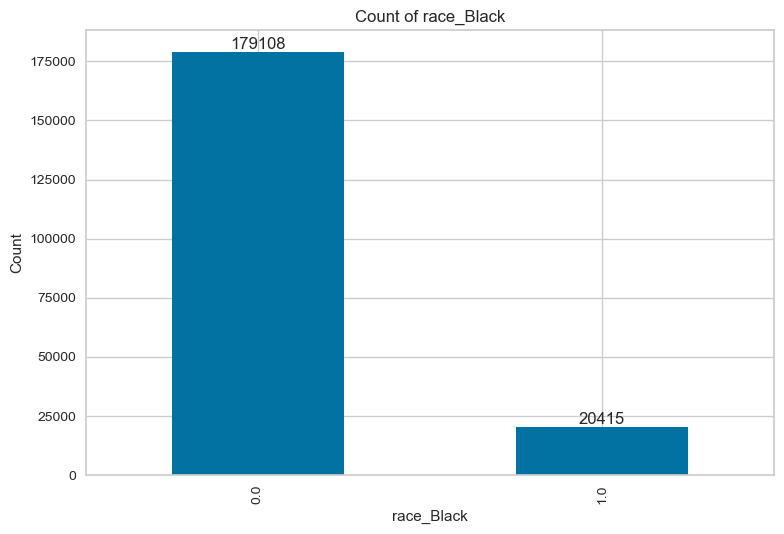

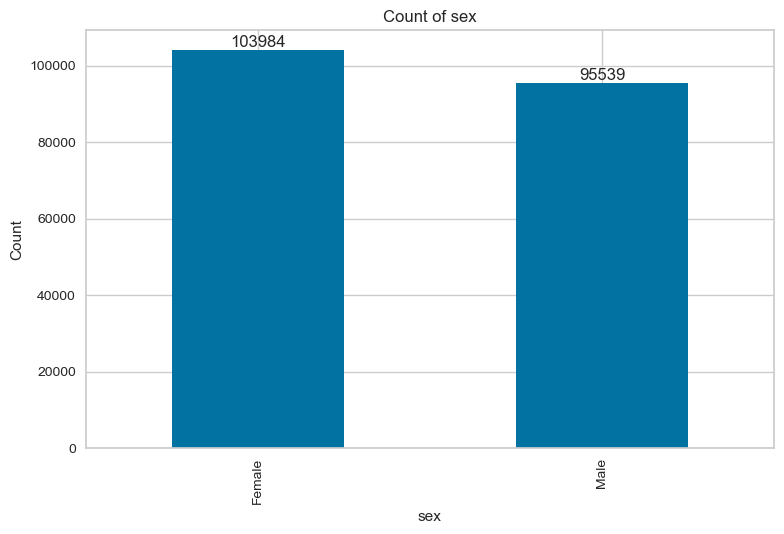

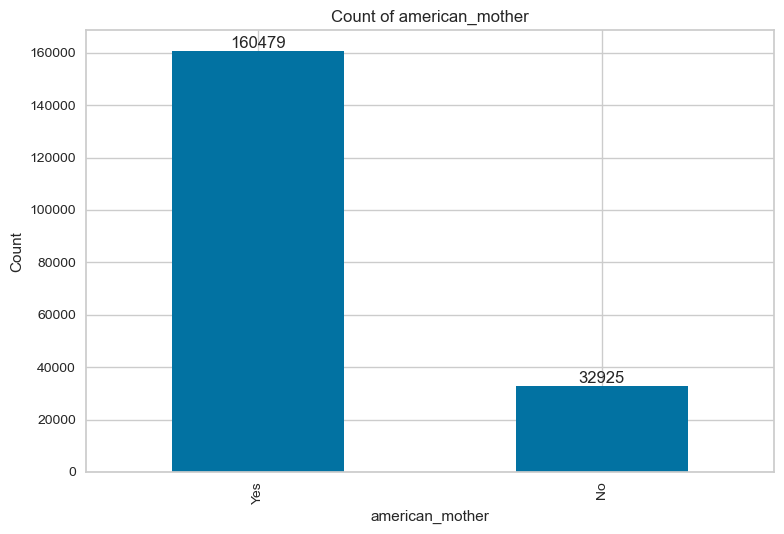

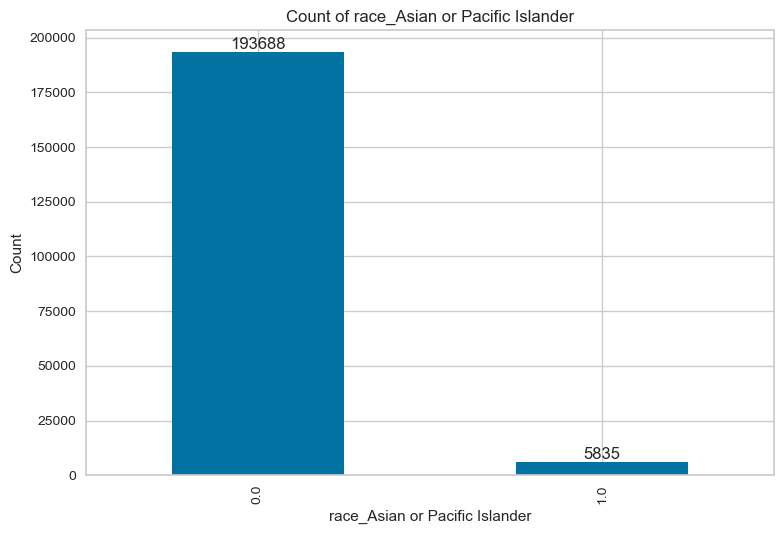

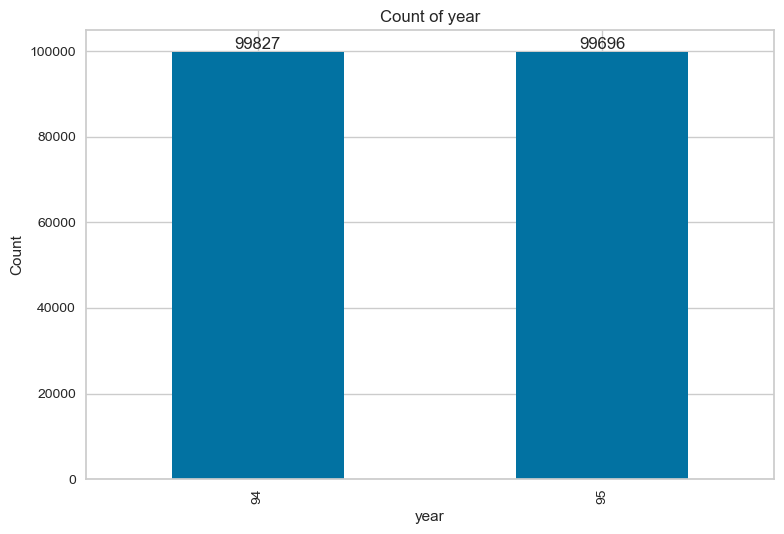

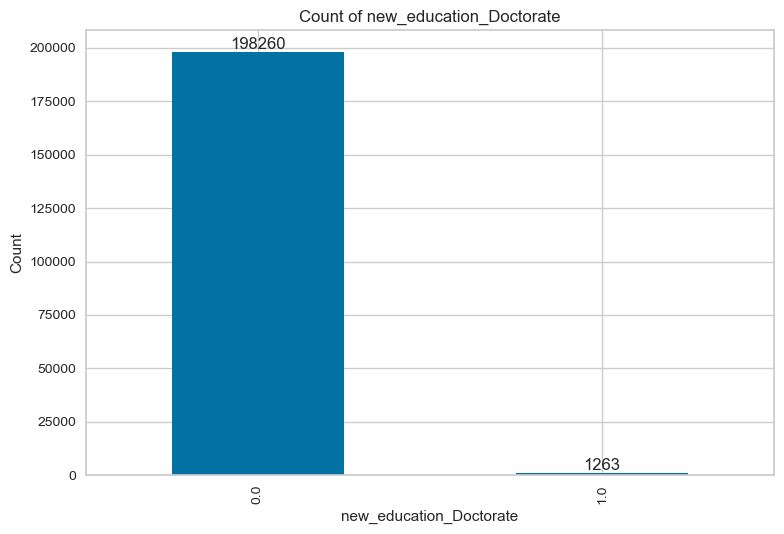

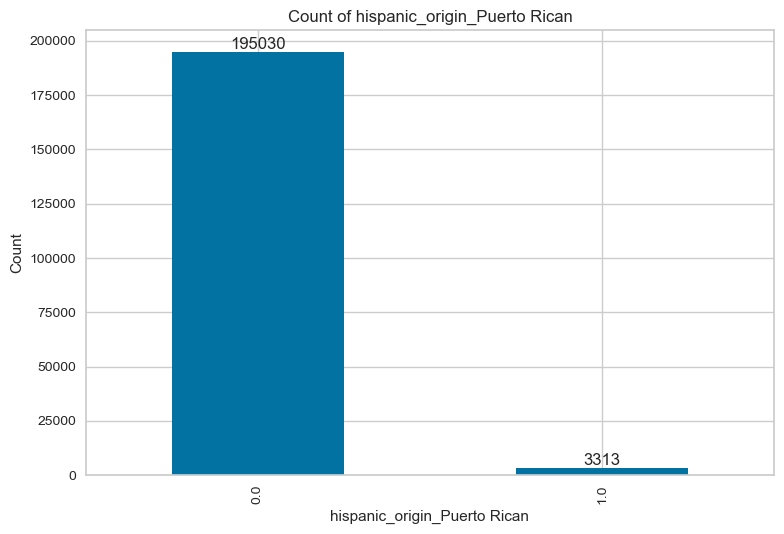

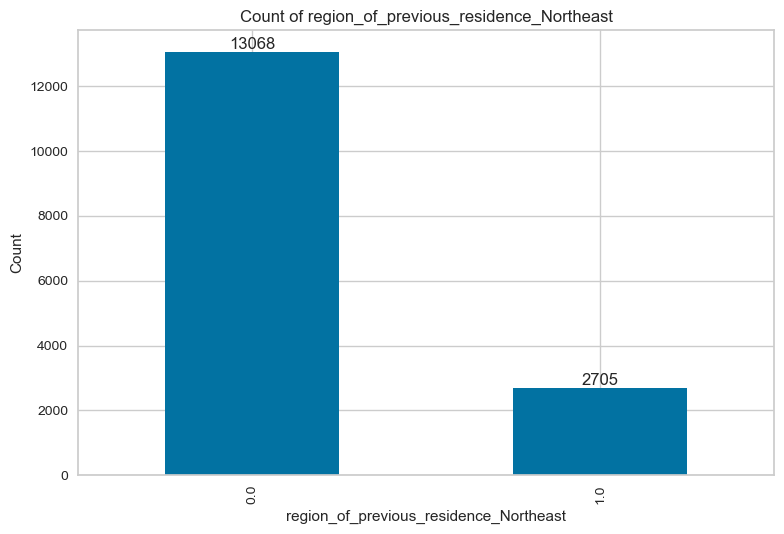

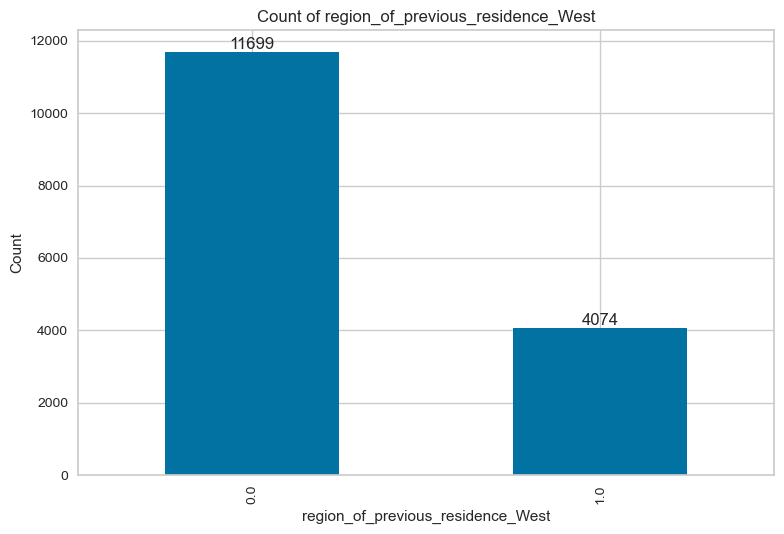

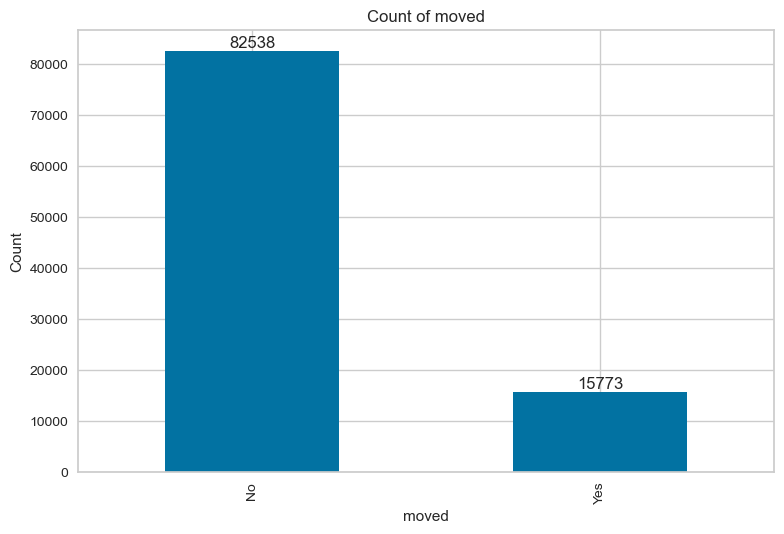

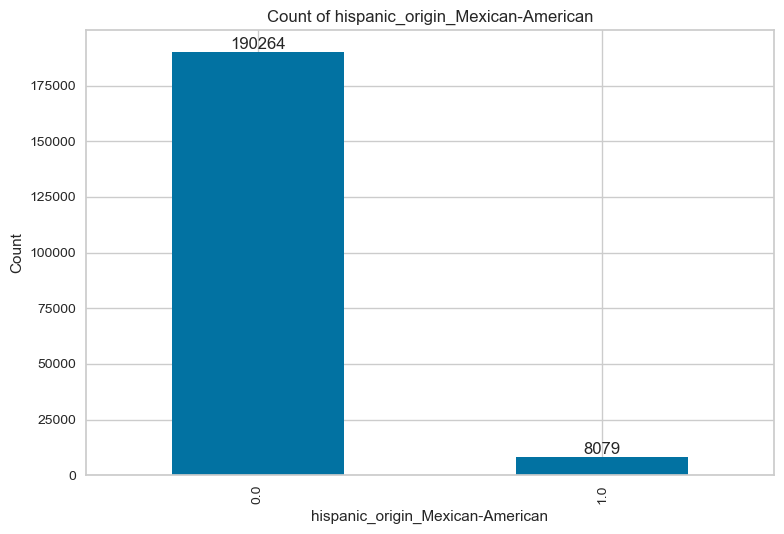

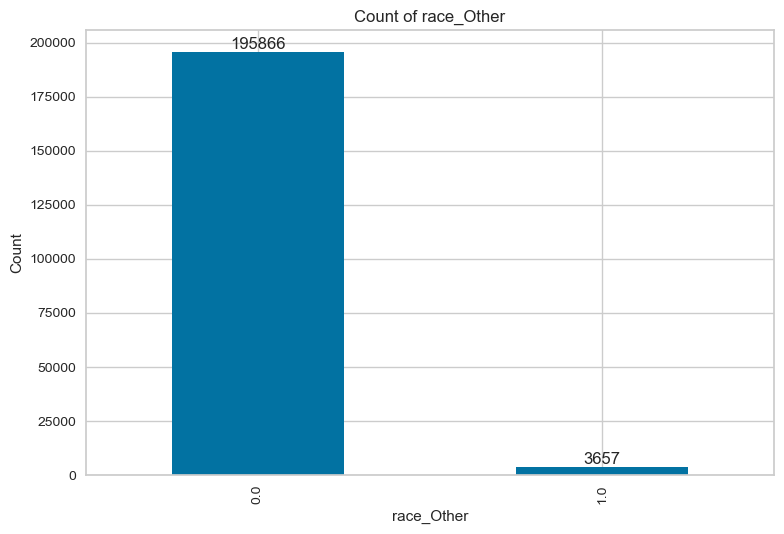

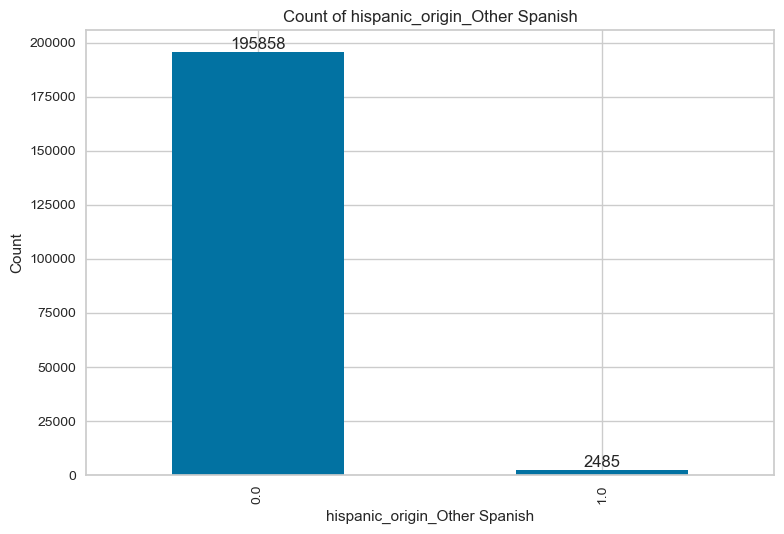

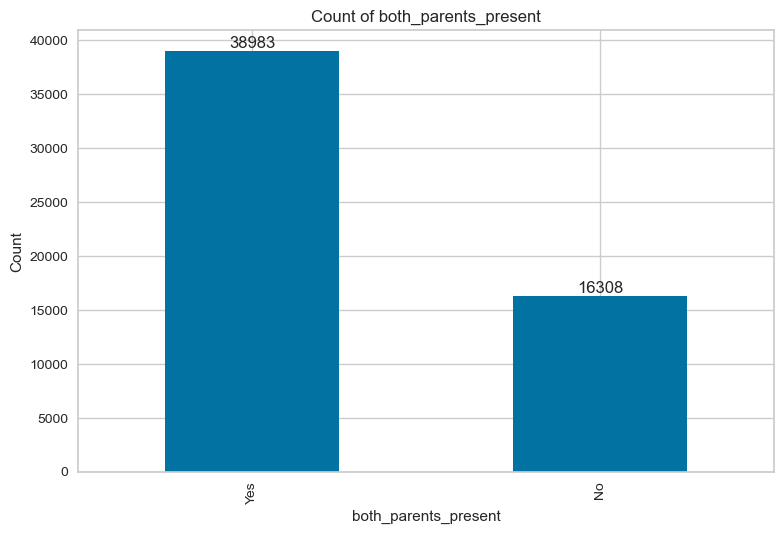

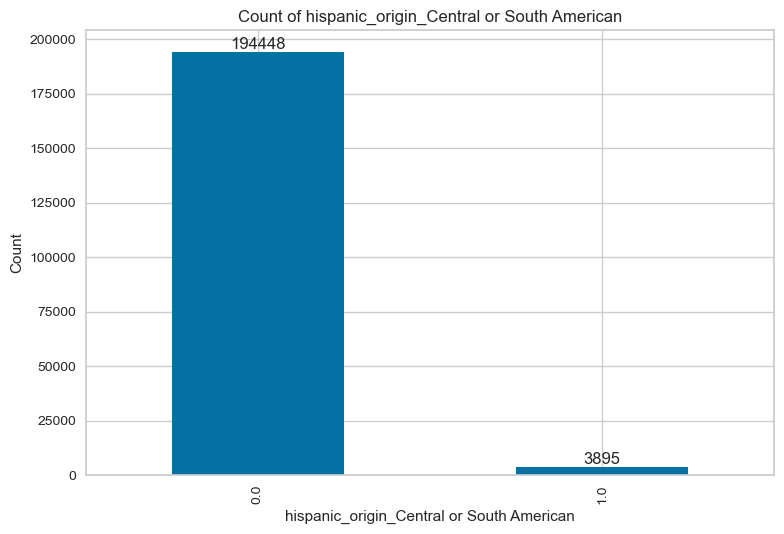

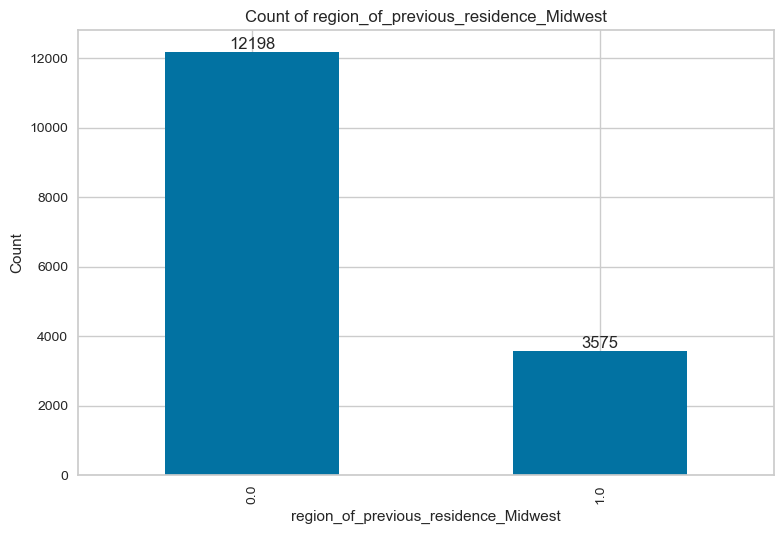

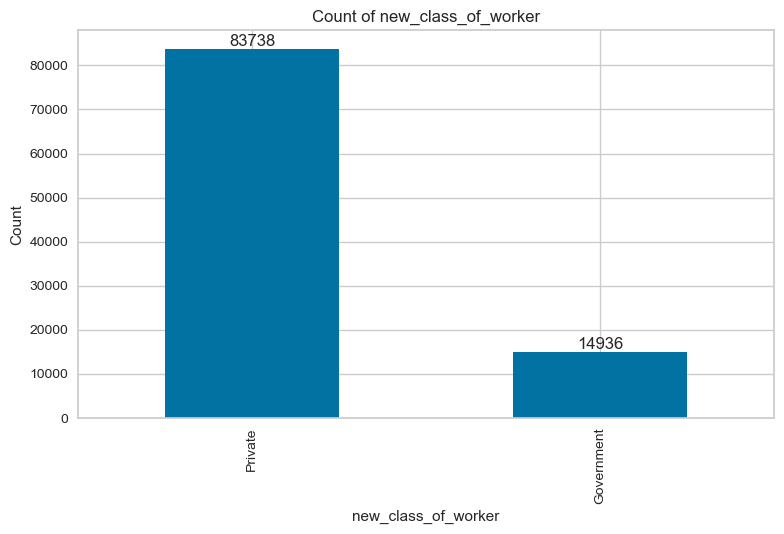

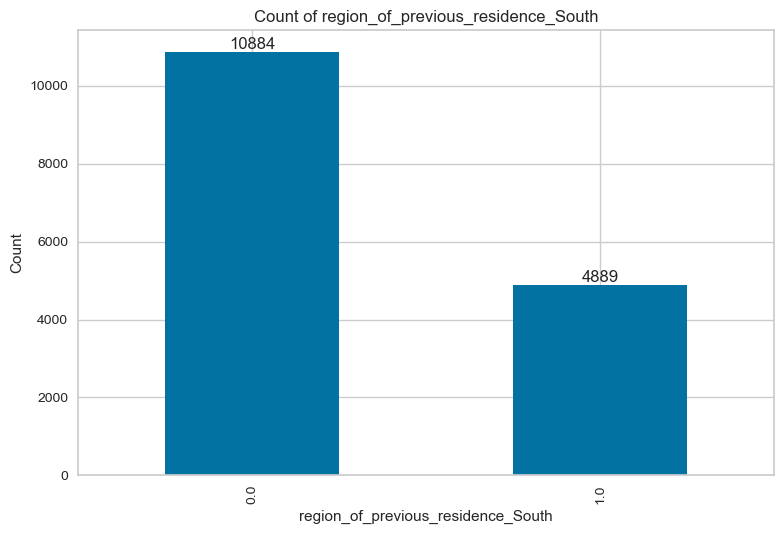

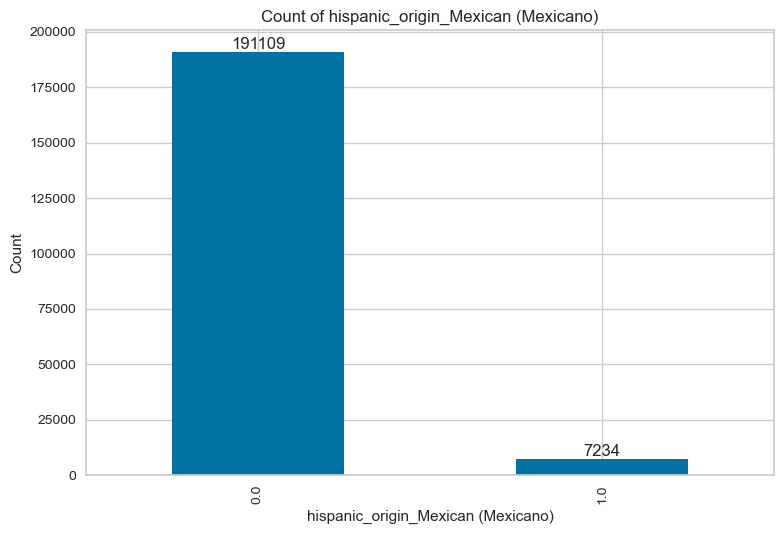

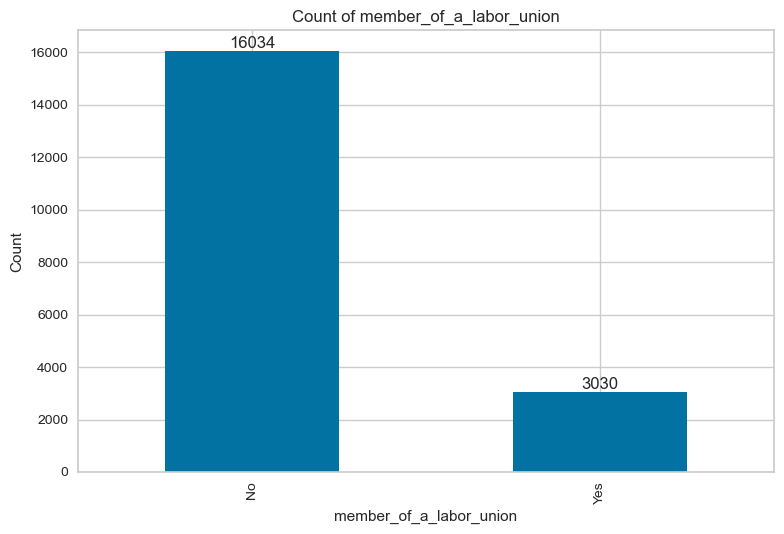

<Figure size 800x550 with 0 Axes>

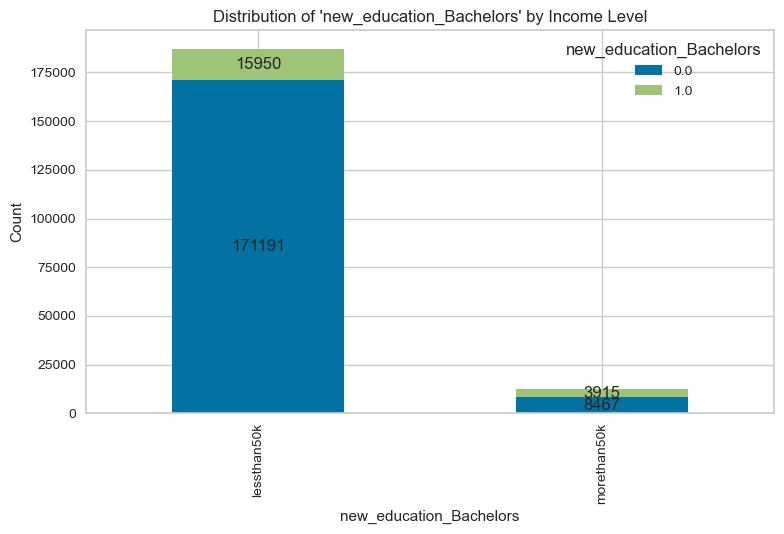

<Figure size 800x550 with 0 Axes>

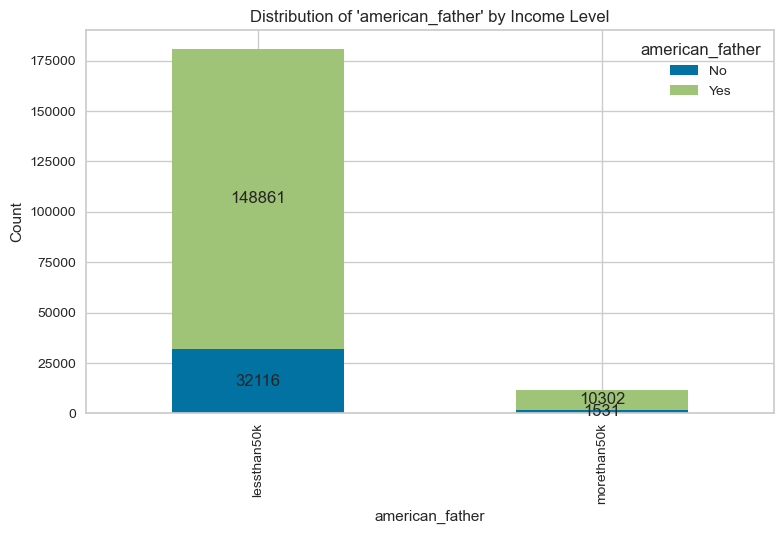

<Figure size 800x550 with 0 Axes>

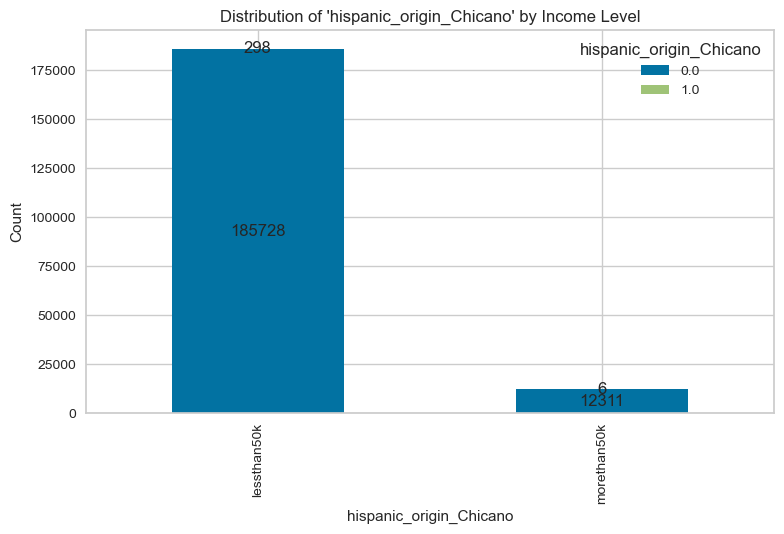

<Figure size 800x550 with 0 Axes>

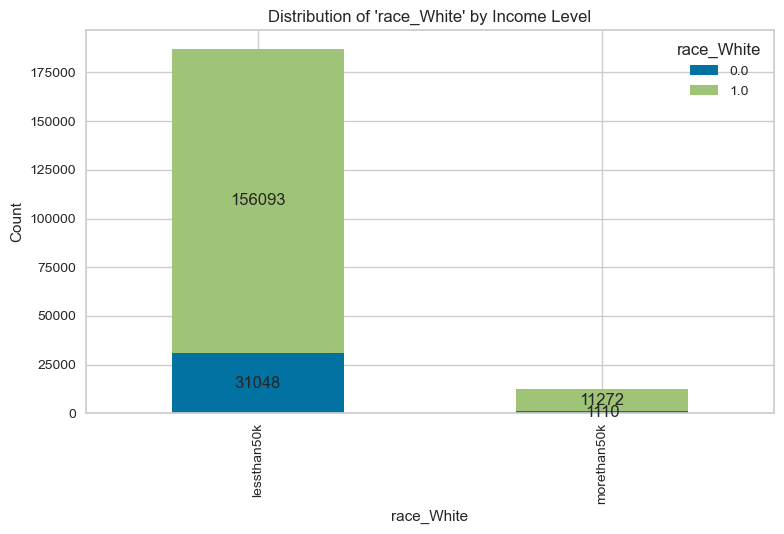

<Figure size 800x550 with 0 Axes>

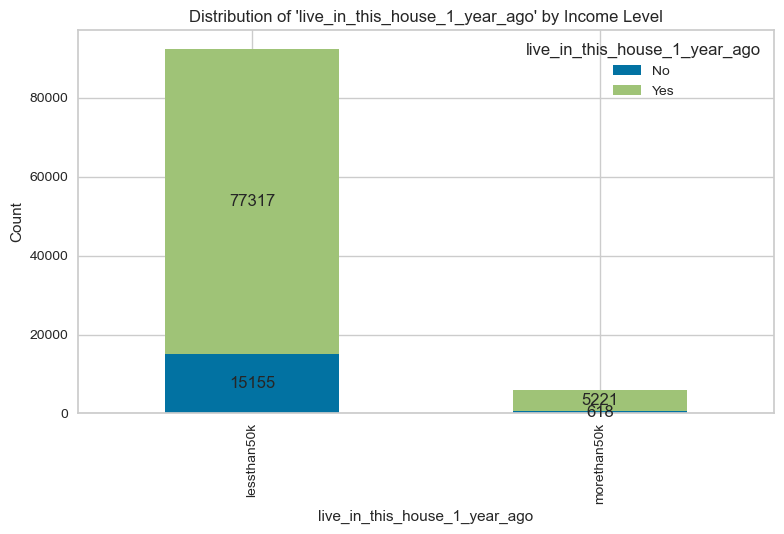

<Figure size 800x550 with 0 Axes>

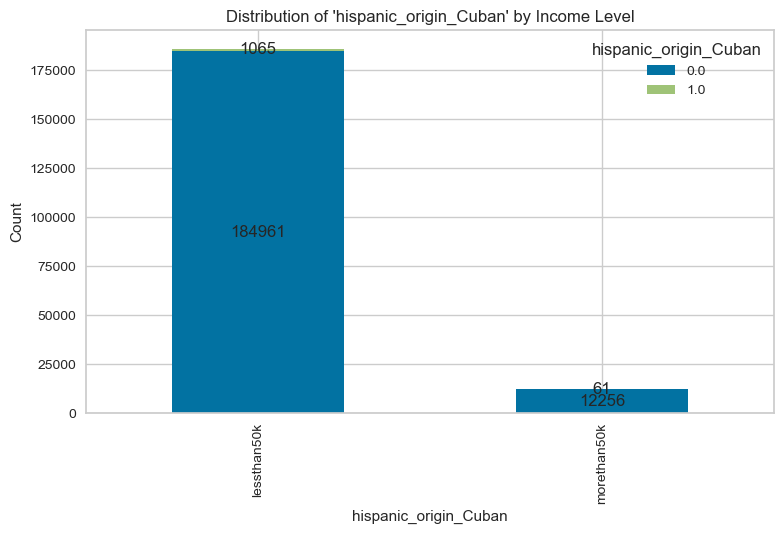

<Figure size 800x550 with 0 Axes>

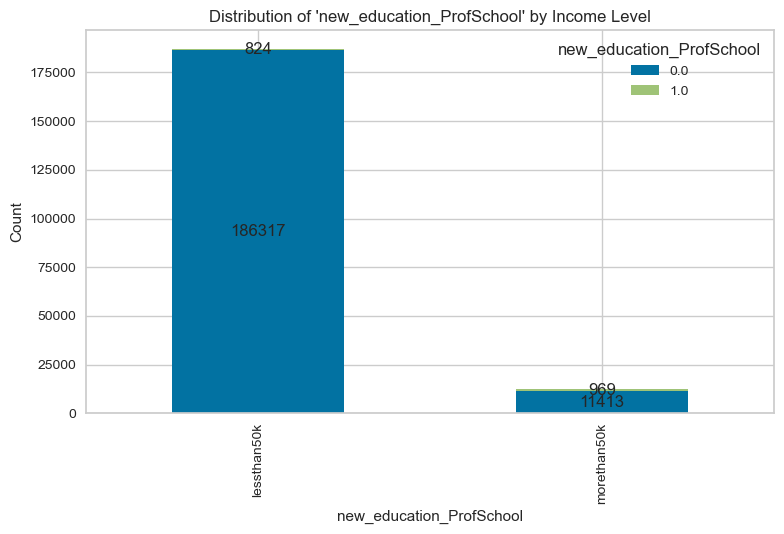

<Figure size 800x550 with 0 Axes>

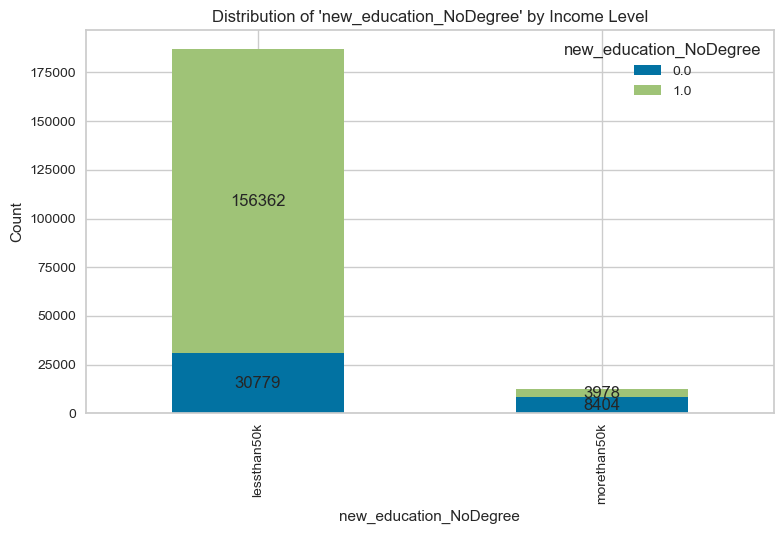

<Figure size 800x550 with 0 Axes>

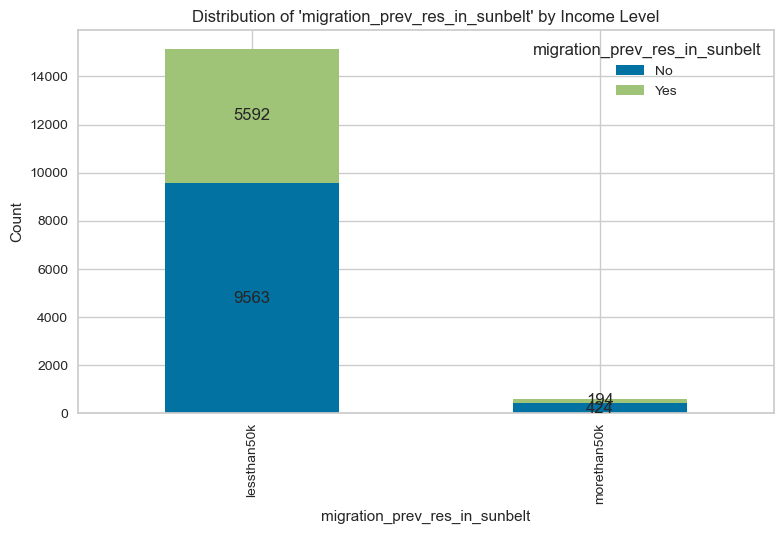

<Figure size 800x550 with 0 Axes>

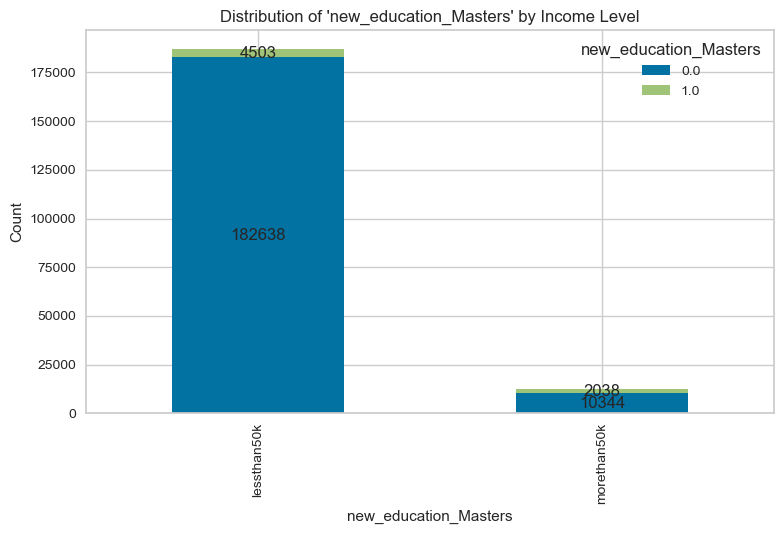

<Figure size 800x550 with 0 Axes>

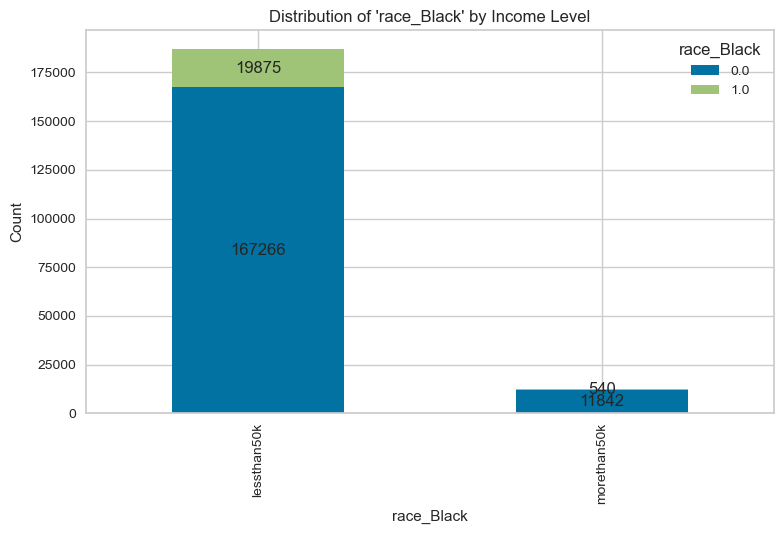

<Figure size 800x550 with 0 Axes>

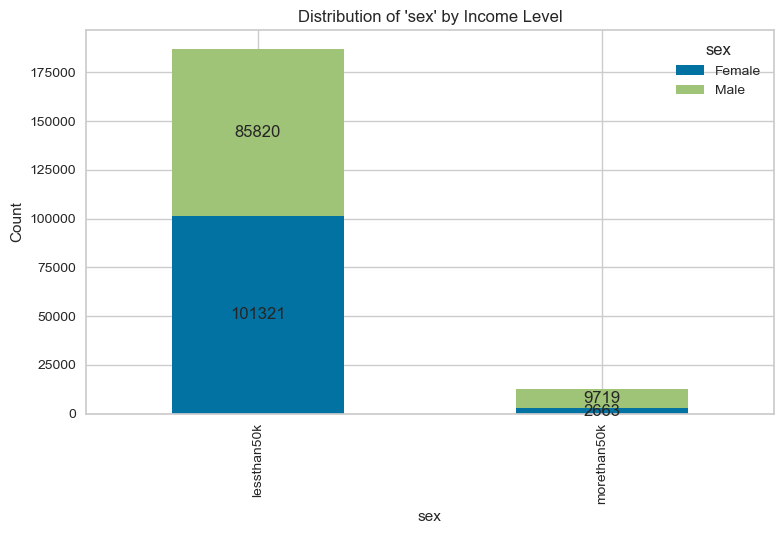

<Figure size 800x550 with 0 Axes>

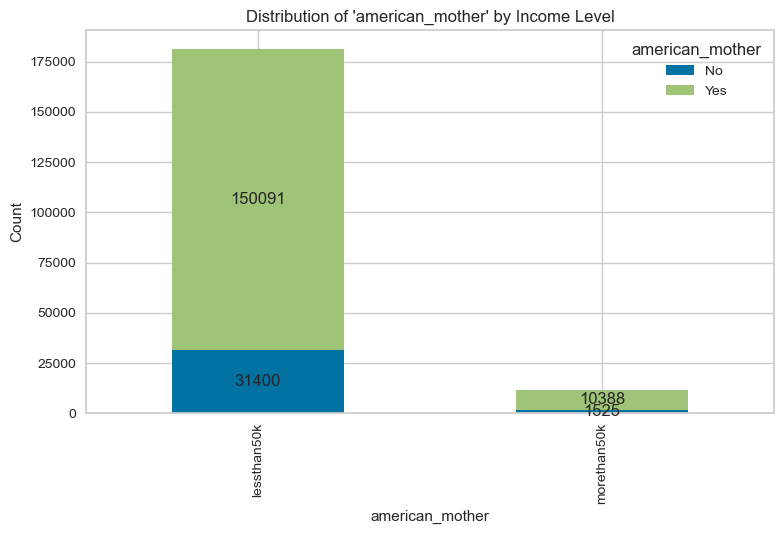

<Figure size 800x550 with 0 Axes>

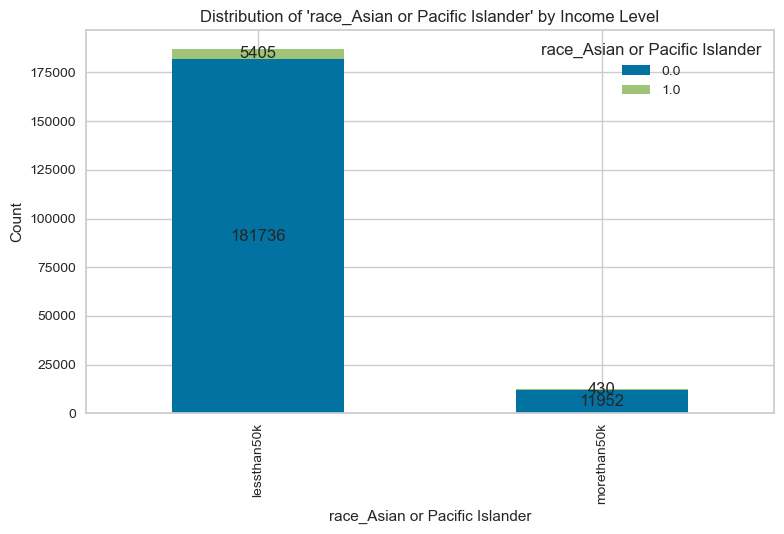

<Figure size 800x550 with 0 Axes>

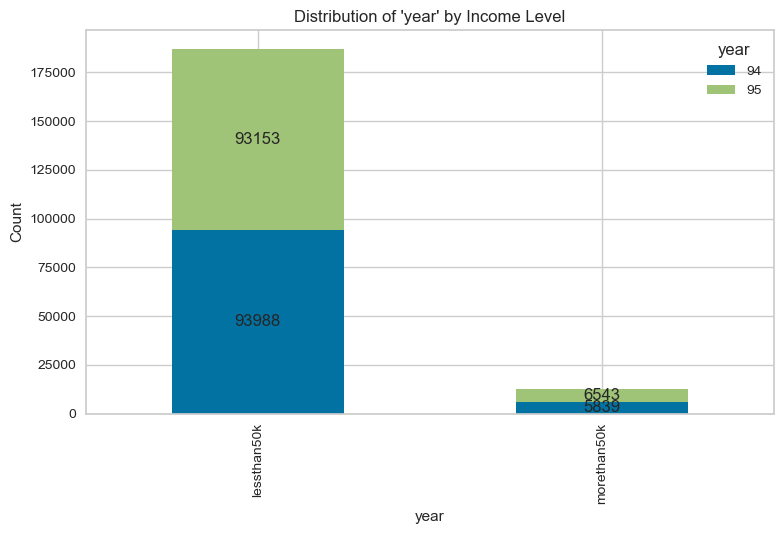

<Figure size 800x550 with 0 Axes>

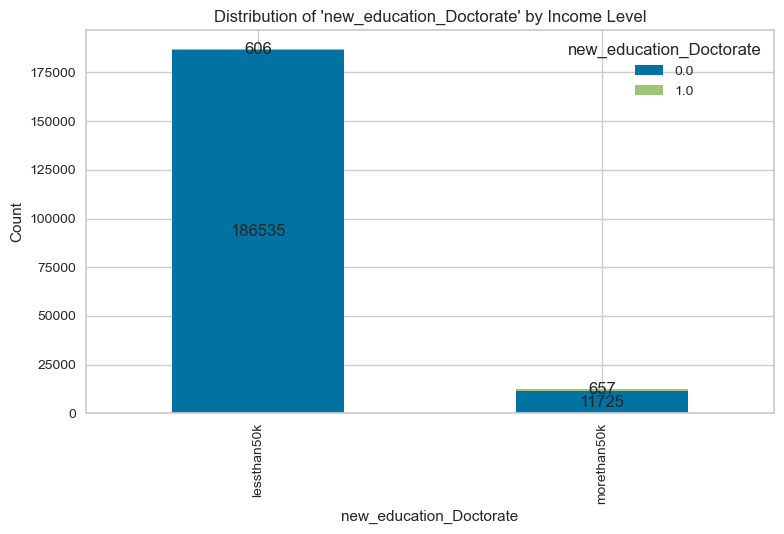

<Figure size 800x550 with 0 Axes>

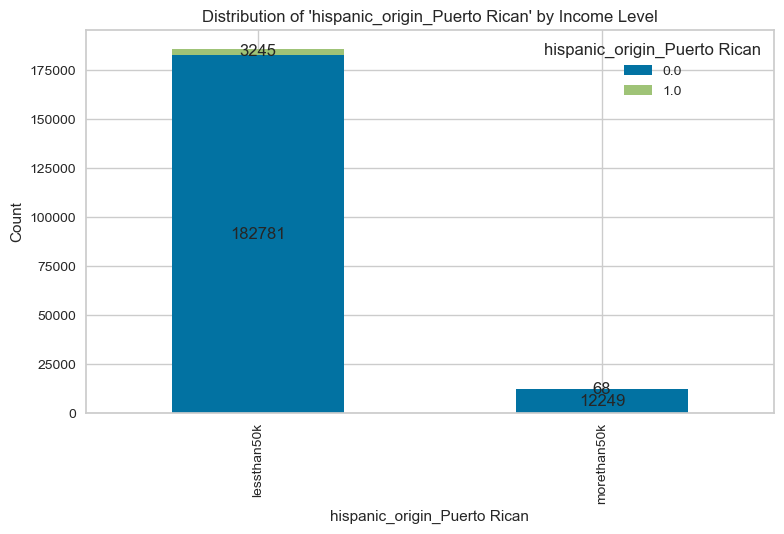

<Figure size 800x550 with 0 Axes>

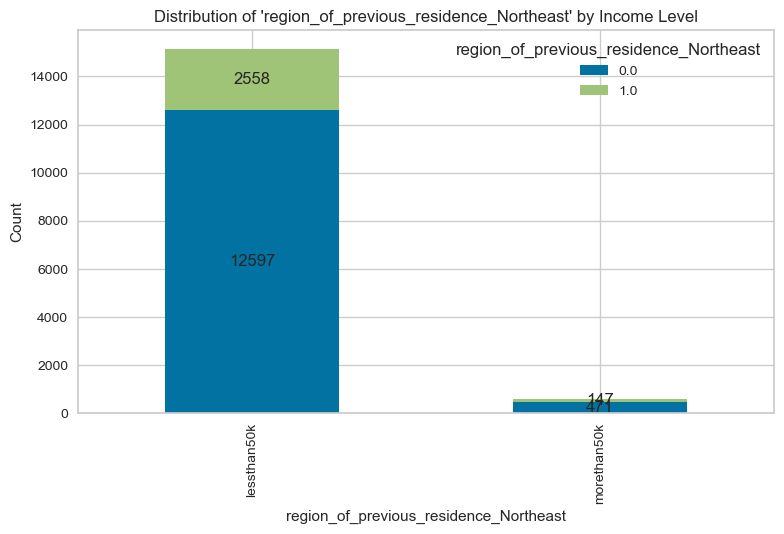

<Figure size 800x550 with 0 Axes>

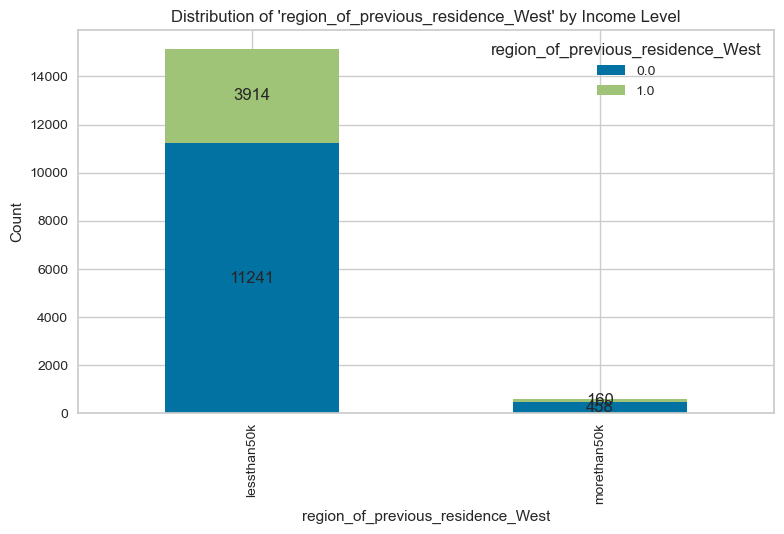

<Figure size 800x550 with 0 Axes>

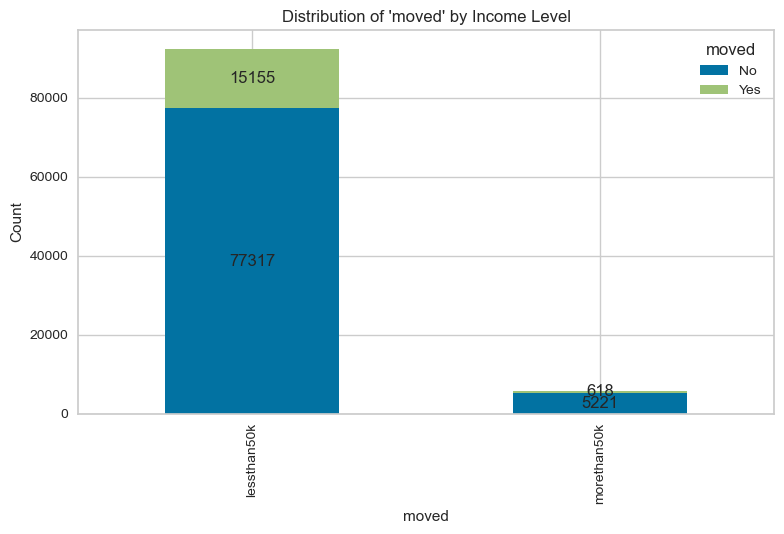

<Figure size 800x550 with 0 Axes>

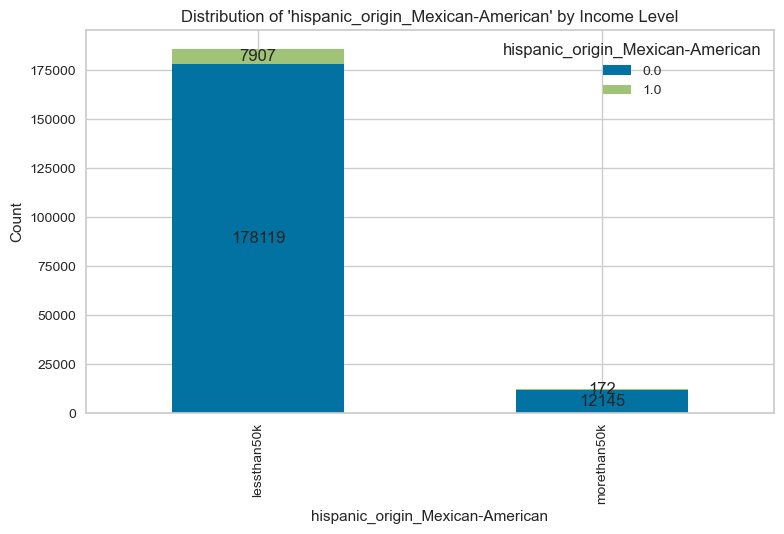

<Figure size 800x550 with 0 Axes>

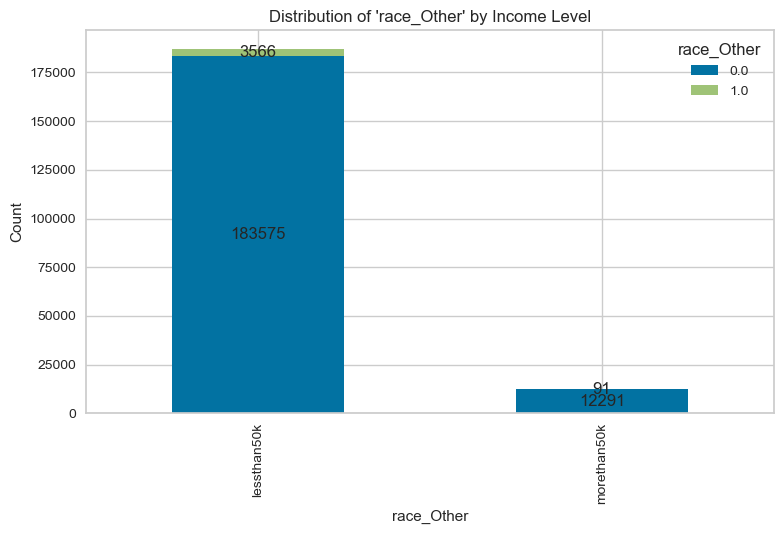

<Figure size 800x550 with 0 Axes>

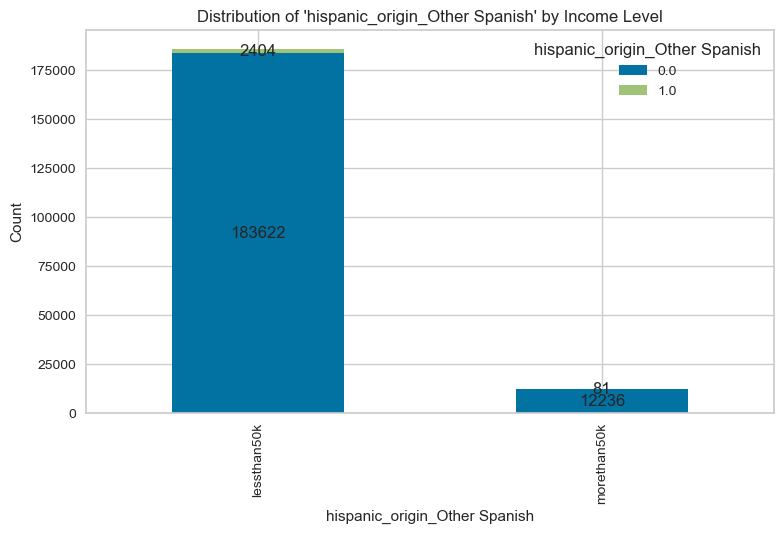

<Figure size 800x550 with 0 Axes>

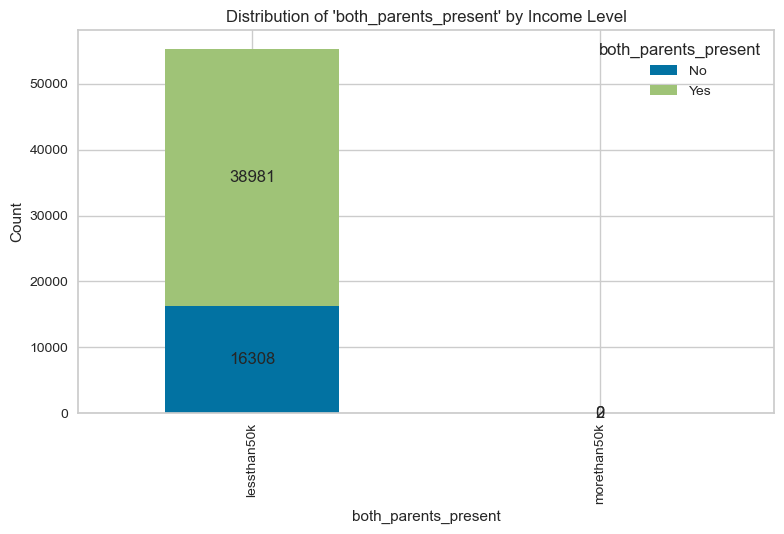

<Figure size 800x550 with 0 Axes>

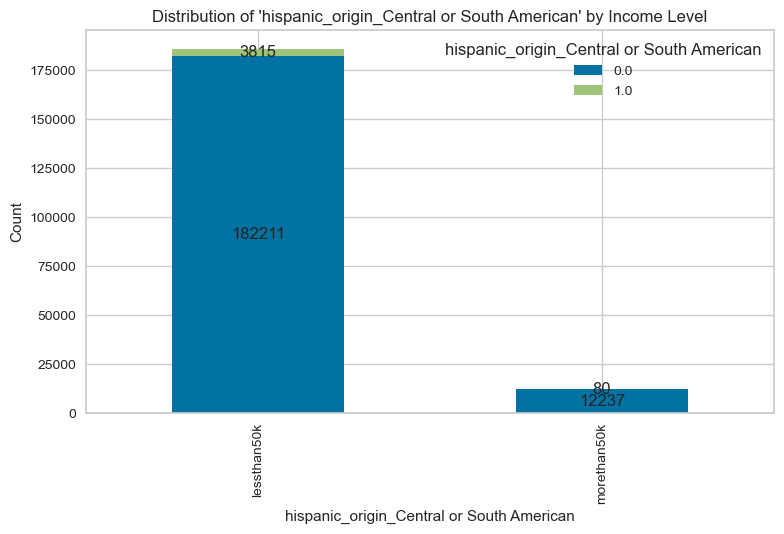

<Figure size 800x550 with 0 Axes>

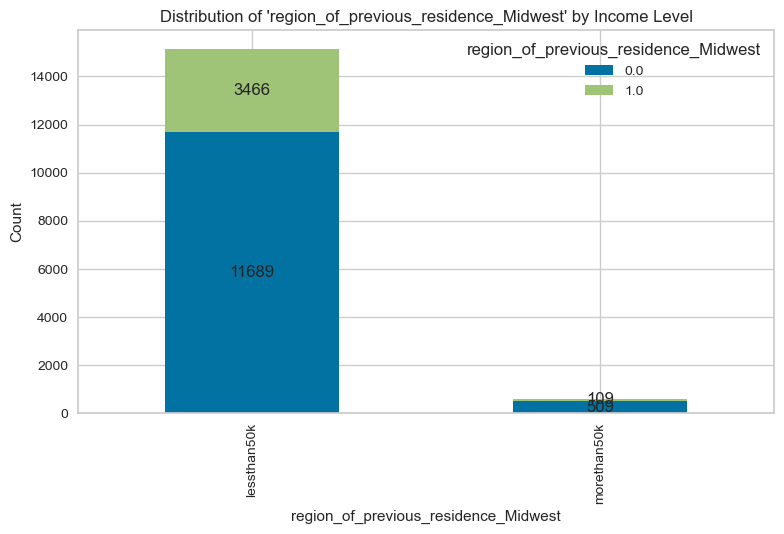

<Figure size 800x550 with 0 Axes>

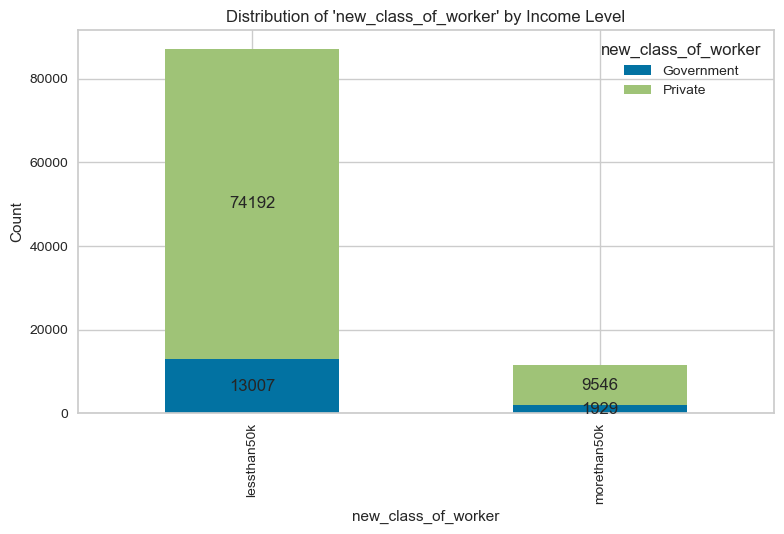

<Figure size 800x550 with 0 Axes>

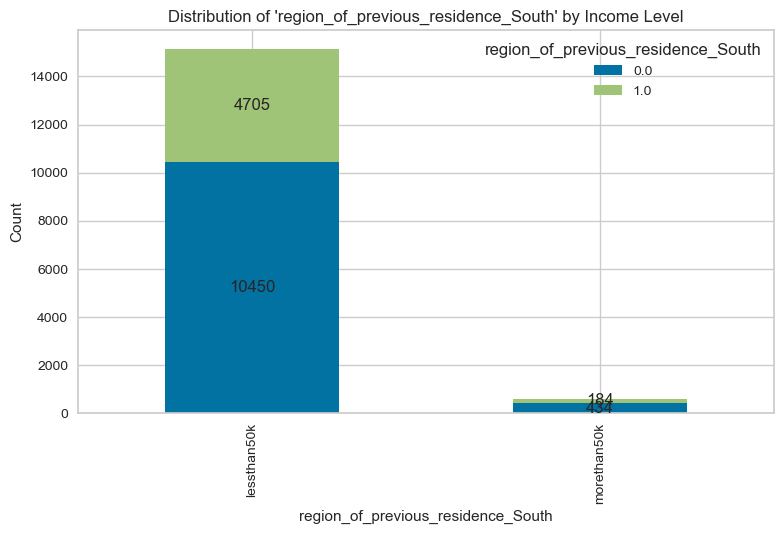

<Figure size 800x550 with 0 Axes>

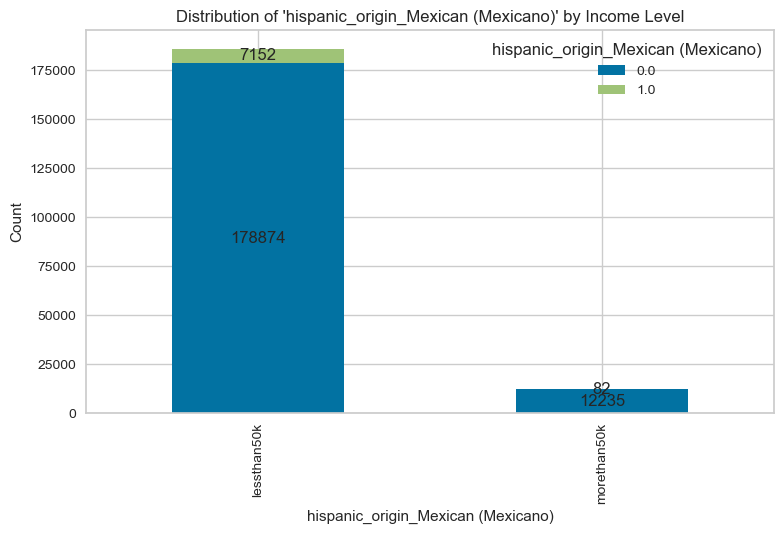

<Figure size 800x550 with 0 Axes>

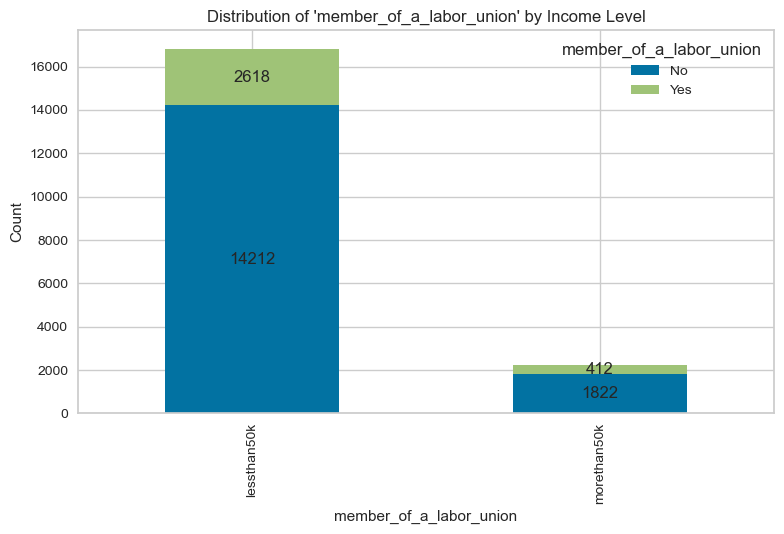

In [19]:
if MAKE_PLOTS:
    if SAVE_PLOTS:
        plotfilename = f'{out_dir}/EDA-train.pdf'
        pdf = PdfPages(plotfilename)
    
    # barplot of target variable
    plt.figure()
    ax = census_df_clean['target'].value_counts().plot(kind="bar")
    for container in ax.containers:
        ax.bar_label(container, label_type='edge', fmt='%.0f')
    ax.set_title(f"Target Variable Distribution")
    ax.set_xlabel("Income Level")
    ax.set_ylabel("Count")
    plt.tight_layout()
    if SAVE_PLOTS:
        pdf.savefig()
    plt.show()
    plt.close()

    # histograms of numerical variables
    for col in vars_keep_numerical:
        plt.figure()
        census_df_clean[col].hist(bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        if SAVE_PLOTS:
            pdf.savefig()
        plt.show()
        plt.close()
    
    # boxplots showing distribution of target variable for each numerical variable
    for col in vars_keep_numerical:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='target', y=col, data=census_df_clean, showfliers=False, palette="Set2")
        plt.title(f"Distribution of {col} by Income Level")
        plt.xlabel("Income Level")
        plt.ylabel(col)
        if SAVE_PLOTS:
            pdf.savefig()
        plt.show()
        plt.close()
    
    # barplots of categorical variables
    for col in vars_keep_categorical:
        plt.figure()
        ax = census_df_clean[col].value_counts().plot(kind="bar")
        for container in ax.containers:
            ax.bar_label(container, label_type='edge', fmt='%.0f')
        ax.set_title(f"Count of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        if SAVE_PLOTS:
            pdf.savefig()
        plt.show()
        plt.close()
    
    # stacked bar charts showing distribution of categorical variables by the target variable
    for col in vars_keep_categorical:
        group_counts = census_df_clean.groupby(["target", col]).size().unstack(fill_value=0)
        plt.figure()
        ax = group_counts.plot(kind="bar", stacked=True)
        for container in ax.containers:
            ax.bar_label(container, label_type='center', fmt='%.0f')
        ax.set_title(f"Distribution of '{col}' by Income Level")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        if SAVE_PLOTS:
            pdf.savefig()
        plt.show()
        plt.close()
    
    if SAVE_PLOTS:
        pdf.close()
        custom_print(f"All plots saved to '{plotfilename}'")

In [20]:
if FULL_VERBOSE:
    # mean of target variable levels in each numerical variable
    census_df_clean.groupby("target")[vars_keep_numerical].mean()

In [21]:
if FULL_VERBOSE:
    # calculate % of males and females in each income level
    gender_counts = census_df_clean.groupby(["target", "sex"]).size().unstack(fill_value=0)
    gender_percentages = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100
    print(gender_percentages)

    # print out the percentages
    less_than_50k_female = gender_percentages.loc['lessthan50k', 'Female']
    less_than_50k_male = gender_percentages.loc['lessthan50k', 'Male']
    more_than_50k_female = gender_percentages.loc['morethan50k', 'Female']
    more_than_50k_male = gender_percentages.loc['morethan50k', 'Male']

    print(f"{less_than_50k_female:.2f}% women in the 'less than 50k' group compared to {more_than_50k_female:.2f}% in the 'more than 50k' group")
    print(f"{less_than_50k_male:.2f}% men in the 'less than 50k' group compared to {more_than_50k_male:.2f}% in the 'more than 50k' group")

    # 54% women in the "less than 50k" group compared to 22% in the "more than 50k" group
    # 46% men in the "less than 50k" group compared to 78% in the "more than 50k" group

sex             Female       Male
target                           
lessthan50k  54.141530  45.858470
morethan50k  21.507026  78.492974
54.14% women in the 'less than 50k' group compared to 21.51% in the 'more than 50k' group
45.86% men in the 'less than 50k' group compared to 78.49% in the 'more than 50k' group


In [22]:
# "both_parents_present" has only 2 observations for "morethan50k" hence dropping it
#census_df_clean = census_df_clean.drop(columns=['both_parents_present'])
vars_keep_categorical = [var for var in vars_keep_categorical if var != 'both_parents_present']

# keep only the categorical and numerical variables to be used for modeling
census_df_final = census_df_clean[vars_keep_categorical + vars_keep_numerical + ['target']]

In [23]:
# print number of rows and columns in the final census dataset
custom_print(f"Number of rows (final): {census_df_final.shape[0]}")
custom_print(f"Number of columns (final): {census_df_final.shape[1]}")

# show what the data looks like
custom_print(f"Cleaned data:\n{census_df_final.head()}")

################################################################################
Number of rows (final): 199523
################################################################################


################################################################################
Number of columns (final): 36
################################################################################


################################################################################
Cleaned data:
   new_education_Bachelors american_father  hispanic_origin_Chicano  \
0                      0.0             Yes                      0.0   
1                      0.0             Yes                      0.0   
2                      0.0              No                      0.0   
3                      0.0             Yes                      0.0   
4                      0.0             Yes                      0.0   

   race_White live_in_this_house_1_year_ago  hispanic_origin_Cuban  \
0         1.0      

In [24]:
if FULL_VERBOSE:
    # info about all variables
    print(census_df_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 36 columns):
 #   Column                                     Non-Null Count   Dtype   
---  ------                                     --------------   -----   
 0   new_education_Bachelors                    199523 non-null  float64 
 1   american_father                            192810 non-null  object  
 2   hispanic_origin_Chicano                    198343 non-null  float64 
 3   race_White                                 199523 non-null  float64 
 4   live_in_this_house_1_year_ago              98311 non-null   object  
 5   hispanic_origin_Cuban                      198343 non-null  float64 
 6   new_education_ProfSchool                   199523 non-null  float64 
 7   new_education_NoDegree                     199523 non-null  float64 
 8   migration_prev_res_in_sunbelt              15773 non-null   object  
 9   new_education_Masters                      199523 non-null  float64 
 

## ML Modeling

* Now building random forest, logistic regression, xgboost and lightgbm models over 10 iterations to select the most robust ML model

In [25]:
# setting ml models to build
ml_models = ['rf','xgboost','lightgbm','lr','knn','dt']

In [26]:
# pycaret setup
setup(data=census_df_final,
      target='target',
      train_size=0.8,
      verbose=True,
      session_id=123,
      experiment_name='census-training',
      categorical_features=vars_keep_categorical,
      numeric_features=vars_keep_numerical,
      remove_outliers=False,
      preprocess=True,
      normalize=True,
      normalize_method='zscore',
      transformation=True,
      transformation_method='quantile',
      fix_imbalance=True,
      fix_imbalance_method='smote',
      fold=5,
      fold_strategy='stratifiedkfold',
      fold_shuffle=True,
      numeric_imputation = 'median',
      categorical_imputation = 'mode'
)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Target mapping,"lessthan50k: 0, morethan50k: 1"
4,Original data shape,"(199523, 36)"
5,Transformed data shape,"(339329, 36)"
6,Transformed train set shape,"(299424, 36)"
7,Transformed test set shape,"(39905, 36)"
8,Numeric features,6
9,Categorical features,29


target
lessthan50k    149712
morethan50k      9906
Name: count, dtype: int64
target
0    149712
1    149712
Name: count, dtype: int64


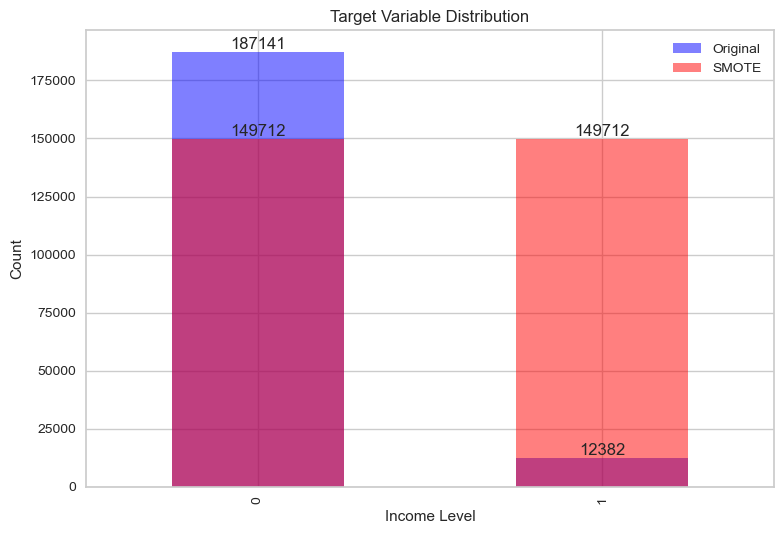

In [27]:
# show difference in outcome variable after applying SMOTE
print(get_config('y_train').value_counts())
print(get_config('y_train_transformed').value_counts())

# plot difference in outcome variable after applying SMOTE
plt.figure()
ax = census_df_final['target'].value_counts().plot(kind='bar', color='blue', alpha=0.5, label='Original')
get_config('y_train_transformed').value_counts().plot(kind='bar', color='red', alpha=0.5, label='SMOTE')
plt.legend()
plt.title('Target Variable Distribution')
plt.xlabel('Income Level')
plt.ylabel('Count')
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fmt='%.0f')
plt.tight_layout()
#plt.savefig(f'{out_dir}/target_variable_distribution.png')
plt.show()

In [28]:
# compare training set metrics between different classification models to find the best performer
best_models = compare_models(include=ml_models, sort='AUC', n_select=7)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9095,0.9162,0.9095,0.9364,0.9203,0.4165,0.4345,1.9300
xgboost,Extreme Gradient Boosting,0.9098,0.9125,0.9098,0.9356,0.9202,0.4126,0.4293,1.8700
lr,Logistic Regression,0.8336,0.8832,0.8336,0.9344,0.8705,0.2915,0.3566,1.2280
rf,Random Forest Classifier,0.9111,0.8720,0.9111,0.9260,0.9177,0.3532,0.3588,5.0540
knn,K Neighbors Classifier,0.9343,0.8093,0.9343,0.9306,0.9323,0.4023,0.4033,11.7780
dt,Decision Tree Classifier,0.9019,0.7280,0.9019,0.9232,0.9112,0.3232,0.3317,1.2840


In [29]:
# print hyperparameters for all models
for idx in range(len(best_models)):
    print(f"Model {idx+1} Hyperparameters:")
    print(best_models[idx])
    print("#" * 80)

Model 1 Hyperparameters:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
################################################################################
Model 2 Hyperparameters:
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=Non

In [30]:
# compare testing set metrics between different classification models to find the best performer
for idx in range(len(best_models)):
    mytemp = predict_model(best_models[idx])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9058,0.9144,0.9058,0.9357,0.9178,0.4064,0.4266


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9062,0.9112,0.9062,0.9353,0.9179,0.4046,0.4239


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8301,0.8788,0.8301,0.9333,0.8681,0.2831,0.3478


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9063,0.8700,0.9063,0.9254,0.9146,0.3433,0.3512


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9343,0.8075,0.9343,0.9302,0.9321,0.3979,0.3991


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8971,0.7283,0.8971,0.9228,0.9082,0.3146,0.3255


In [31]:
# finalize the best performing model
final_model = finalize_model(best_models[0])

In [32]:
print(final_model)

Pipeline(memory=Memory(location=None),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'wage_per_hour',
                                             'capital_gains', 'capital_losses',
                                             'dividends_from_stocks',
                                             'weeks_worked_in_year'],
                                    transformer=SimpleImputer(add_indicat...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                         